# missing & outlier 처리

## module

In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

## Data Load


In [2]:
data_path = "../data"
train_path = "train_v2.csv"
test_path = "test.csv"
tr_te = "tr_te.csv"

train = pd.read_csv(os.path.join(data_path,train_path))
test = pd.read_csv(os.path.join(data_path,test_path))

In [3]:
train = train.drop(columns=["Unnamed: 0","Unnamed: 0.1"])

In [4]:
import json

with open("./cols_name.json", "r") as f:
    dict_ = json.load(f)

cols_name_dict = dict_["columns_name"]

category_cols = dict_["category"]

integer_cols = dict_["integer"]

# test data column 명 변경

test.rename(columns=cols_name_dict,inplace=True)

In [5]:
# train + test = df

df = pd.concat([train, test], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2919 non-null   int64  
 1   ms_subclass        2919 non-null   int64  
 2   ms_zoning          2915 non-null   object 
 3   lot_frontage       2433 non-null   float64
 4   lot_area           2919 non-null   int64  
 5   street_access      2919 non-null   object 
 6   alley              198 non-null    object 
 7   lot_shape          2919 non-null   object 
 8   land_contour       2919 non-null   object 
 9   utilities          2917 non-null   object 
 10  lot_config         2919 non-null   object 
 11  land_slope         2919 non-null   object 
 12  neighborhood       2919 non-null   object 
 13  condition1         2919 non-null   object 
 14  condition2         2919 non-null   object 
 15  bldg_type          2919 non-null   object 
 16  house_style        2919 

## Dictionary 및 Function


In [6]:
# central air
def y_n_classify(x):
    if x == "Y":
        return 1
    return 0

def is_exist_fence(x):
    if x == "None":
        return "None"
    return "Exist"

def is_func(x):
    if x == "Typ":
        return 0
    return 1

def is_pool(x):
    if x > 0:
        return 1
    return 0

# category data _ order
basic_qual_cond = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1,
    0 : 0
}

dict_bsmt_exposure = {
    "Gd" : 4,
    "Av" : 3,
    "Mn" : 2,
    "No" : 1,
    0 : 0
}

dict_bsmt_type = {
    "GLQ": 6,
    "ALQ": 5,
    "BLQ": 4,
    "Rec": 3,
    "LwQ": 2,
    "Unf": 1,
    0 : 0
}

dict_electrical = {
    "SBrkr" : 5,
    "FuseA" : 4,
    "FuseF" : 3,
    "Mix" : 2,
    "FuseP" : 1
}

dict_functional = {
    "Typ" : 3,
    "Min1" : 2,
    "Min2" : 2,
    "Mod" : 2,
    "Maj1" : 1,
    "Maj2" : 1,
    "Sev" : 1,
    "Sal" : 1,
}

dict_garage_finish = {
    "Fin" : 2,
    "RFn" : 1,
    "Unf" : 0,
    0 : 0
}

dict_fence_qual = {
    "GdPrv" : 2,
    "MnPrv" : 1,
    "GdWo" : 2,
    "MnWw" : 1,
    0 : 0
}

In [7]:
# columns 분류

# category - 명목형
category1 = ["ms_subclass","ms_zoning","street_access","alley","lot_shape",
             "land_contour","utilities","lot_config","land_slope","neighborhood",
             "condition1","condition2","bldg_type","house_style","roof_style",
             "roof_matl","exterior_1st","exterior_2nd","mas_vnr_type","foundation",
             "heating","central_air","garage_type","paved_drive","misc_feature",
             "sale_type","sale_cond"]

# category - 순서형(점수)
category2 = ["overall_qual","overall_cond","exter_qual","exter_cond","bsmt_qual",
             "bsmt_cond","bsmt_exposure","bsmt_fin_type1","bsmt_fin_type2",
             "heating_qc","electrical","kitchen_qual","functional","fireplace_qual",
             "garage_finish","garage_qual","garage_cond","fence_qual","pool_qual"]

# integer - 이산형 (개수)
integer1 = ["bsmt_full_bath","bsmt_half_bath","full_bath","half_bath","bedroom",
            "kitchen","tot_rms_abv_grd","garage_cars","fireplaces"]

# integer - 연속형 (거리, 면적)
integer2 = ["lot_frontage","lot_area", "mas_vnr_area", "bsmt_fin_sf1", "bsmt_fin_sf2",
            "bsmt_un_sf", "total_bsmt_sf","1st_flr_sf","2nd_flr_sf","low_qual_fin_sf",
            "gr_liv_area","garage_area","wood_deck_sf","open_porch_sf",
            "enclosed_porch_sf","3ssn_porch_sf","screen_porch_sf","pool_area"]

# interger - 연속형 - 가치
integer3 = ["misc_val"]

# 시계열 데이터 년도 혹은 달
time_data = ["year_built", "year_remod_add", "garage_yr_built", "mo_sold", "yr_sold"]

# 차고 관련 컬럼
garage_cols = ["garage_type","garage_finish","garage_qual","garage_cond","garage_cars","garage_yr_built", "garage_area"]

# 지하실 관련 컬럼
bsmt_cols = ["bsmt_qual","bsmt_cond","bsmt_exposure","bsmt_fin_type1","bsmt_fin_type2","bsmt_full_bath","bsmt_half_bath", "bsmt_fin_sf1", "bsmt_fin_sf2","bsmt_un_sf", "total_bsmt_sf"]


all_columns = category1 + category2 + integer1 + integer2 + integer3 + time_data

set(df.columns) - set(all_columns)

{'id', 'sale_price'}

## Missing Value 처리

In [8]:
# 전체 결측치 확인

count = 0
missing_cols= []
a_c = len(df)

for col in df.columns:
    len_ = len(df[df[col].isna()])
    if len_ > 0:
        print(f"col : {col} // count : {len_} / {a_c}")
        count += 1
        missing_cols.append(col)
        
    
print(f"결측치 columns의 개수 : {count}")

col : ms_zoning // count : 4 / 2919
col : lot_frontage // count : 486 / 2919
col : alley // count : 2721 / 2919
col : utilities // count : 2 / 2919
col : exterior_1st // count : 1 / 2919
col : exterior_2nd // count : 1 / 2919
col : mas_vnr_type // count : 1766 / 2919
col : mas_vnr_area // count : 15 / 2919
col : bsmt_qual // count : 81 / 2919
col : bsmt_cond // count : 82 / 2919
col : bsmt_exposure // count : 82 / 2919
col : bsmt_fin_type1 // count : 79 / 2919
col : bsmt_fin_sf1 // count : 1 / 2919
col : bsmt_fin_type2 // count : 80 / 2919
col : bsmt_fin_sf2 // count : 1 / 2919
col : bsmt_un_sf // count : 1 / 2919
col : total_bsmt_sf // count : 1 / 2919
col : electrical // count : 1 / 2919
col : bsmt_full_bath // count : 2 / 2919
col : bsmt_half_bath // count : 2 / 2919
col : kitchen_qual // count : 1 / 2919
col : functional // count : 2 / 2919
col : fireplace_qual // count : 1420 / 2919
col : garage_type // count : 157 / 2919
col : garage_yr_built // count : 159 / 2919
col : garage_fi

### 명목형 데이터 결측치 제거하기

In [9]:
# 명목형 데이터중 결측치 확인

ca1_m_cols = set(category1).intersection(set(missing_cols))

ca1_m_cols

{'alley',
 'exterior_1st',
 'exterior_2nd',
 'garage_type',
 'mas_vnr_type',
 'misc_feature',
 'ms_zoning',
 'sale_type',
 'utilities'}

#### alley : 골목길 접근 여부

In [10]:
# alley 
train["alley"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: alley
Non-Null Count  Dtype 
--------------  ----- 
91 non-null     object
dtypes: object(1)
memory usage: 11.5+ KB


In [11]:
# alley, sale_price

alley_price = train[["alley", "sale_price"]]

alley_price["alley"].fillna("None_alley", inplace=True)

alley_price["alley"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\1384616903.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  alley_price["alley"].fillna("None_alley", inplace=True)
C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\1384616903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alley_price["alley"].fillna("None_alley", inplace=True)


alley
None_alley    1369
Grvl            50
Pave            41
Name: count, dtype: int64

<Axes: xlabel='alley', ylabel='sale_price'>

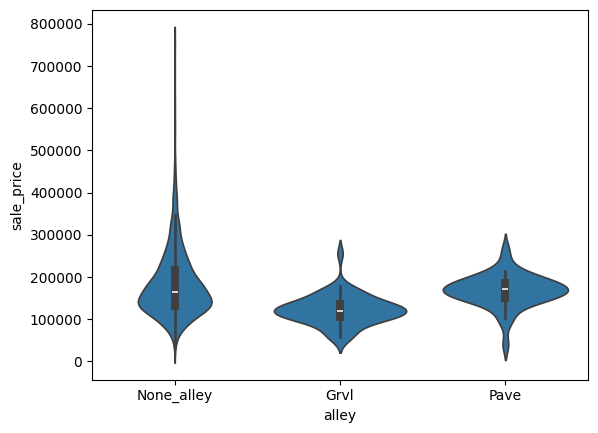

In [12]:
sns.violinplot(data=alley_price, x="alley", y="sale_price")

<Axes: xlabel='alley', ylabel='sale_price'>

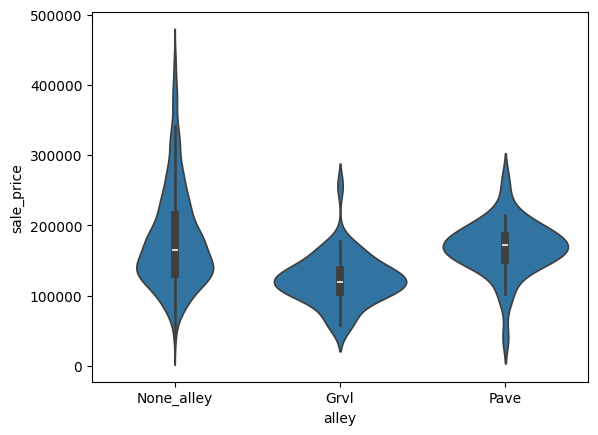

In [13]:
sns.violinplot(data=alley_price[alley_price["sale_price"] <= 450000], x="alley", y="sale_price")

데이터 분포간의 차이는 크지 않다 골목으로 접근한 곳의 가격이 조금더 낮다고 할 수 있는지 잘 모르겠다 Grvl(자갈)의 경우 확실히 값이 낮아지긴 한다.

In [14]:
# alley, neighborhood

alley_nei = train[["alley", "neighborhood"]]

alley_nei["alley"].fillna("None_alley", inplace=True)




C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\1522148202.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  alley_nei["alley"].fillna("None_alley", inplace=True)
C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\1522148202.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alley_nei["alley"].fillna("None_alley", inplace=True)


In [15]:
alley_nei.groupby("alley")["neighborhood"].value_counts()

alley       neighborhood
Grvl        OldTown          36
            Edwards           6
            IDOTRR            5
            Crawfor           1
            NAmes             1
            SWISU             1
None_alley  NAmes           224
            CollgCr         150
            Edwards          94
            Gilbert          79
            NridgHt          77
            Sawyer           74
            NWAmes           73
            OldTown          70
            Somerst          62
            SawyerW          59
            BrkSide          53
            Crawfor          50
            Mitchel          49
            NoRidge          41
            Timber           38
            IDOTRR           30
            ClearCr          28
            StoneBr          25
            SWISU            21
            Blmngtn          17
            MeadowV          17
            BrDale           16
            Veenker          11
            NPkVill           9
            Blu

의미있는 것인지 잘 모르겠다. 그냥 NaN에 대해 처리를 하지 않는 편이 좋을 것 같다. 

In [16]:
# df = df.drop(columns=["alley"])

df.columns

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street_access', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2',
       'bldg_type', 'house_style', 'overall_qual', 'overall_cond',
       'year_built', 'year_remod_add', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area',
       'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond',
       'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_sf1', 'bsmt_fin_type2',
       'bsmt_fin_sf2', 'bsmt_un_sf', 'total_bsmt_sf', 'heating', 'heating_qc',
       'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath', 'half_bath', 'bedroom', 'kitchen', 'kitchen_qual',
       'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qual',
       'garage_type', 'garage_yr_built', 'garage_finish', '

#### exterior1st, exterior2nd

2가지의 변수에 대해 한번에 처리해야한다. 

In [17]:
# exterior1st 

df["exterior_1st"].info()

# exterior_2nd

df["exterior_2nd"].info()


<class 'pandas.core.series.Series'>
RangeIndex: 2919 entries, 0 to 2918
Series name: exterior_1st
Non-Null Count  Dtype 
--------------  ----- 
2918 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 2919 entries, 0 to 2918
Series name: exterior_2nd
Non-Null Count  Dtype 
--------------  ----- 
2918 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [18]:
idx = df[df["exterior_1st"].isna() & df["exterior_2nd"].isna()].index

nei_buy_rey = df.loc[idx][["neighborhood", "year_built", "year_remod_add"]]

nei_buy_rey

,neighborhood,year_built,year_remod_add
2151,Edwards,1940,2007


In [19]:
from scipy.stats.contingency import association

pre_1950_building = df[df["year_built"] <= 1950][["exterior_1st", "exterior_2nd", "neighborhood", "year_built", "year_remod_add"]]

ct = pd.crosstab(index=pre_1950_building["neighborhood"],columns=pre_1950_building["exterior_1st"])

association(ct, method="cramer")



0.15795265642674733

In [20]:
ct = pd.crosstab(index=df["neighborhood"],columns=df["exterior_1st"])

association(ct, method="cramer")


0.30923692020667093

In [21]:
df["year_built_v1"] = df["year_built"].apply(lambda x: (x//10) * 10)

ct = pd.crosstab(index=df["year_built_v1"],columns=df["exterior_1st"])

association(ct, method="cramer")

0.2780930403217881

In [22]:
ct = pd.crosstab(index=[df["neighborhood"],df["year_built_v1"]],columns=df["exterior_1st"])

association(ct, method="cramer")

0.4620028640308209

In [23]:
replace_value = 0
df[(df["neighborhood"] == "Edwards") & (df["year_built_v1"] == 1940)]["exterior_2nd"].value_counts()

exterior_2nd
MetalSd    10
VinylSd     8
Wd Sdng     7
Wd Shng     3
Plywood     2
Name: count, dtype: int64

In [24]:
replace_value = "MetalSd"

df.loc[idx,"exterior_1st"] = replace_value

df.loc[idx,"exterior_2nd"] = replace_value



#### garage_type

In [25]:
df["garage_type"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2919 entries, 0 to 2918
Series name: garage_type
Non-Null Count  Dtype 
--------------  ----- 
2762 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [26]:
miss_idx = df[df["garage_type"].isna()].index

garage_cols = ["garage_type","garage_finish","garage_qual","garage_cond","garage_cars","garage_yr_built", "garage_area"]

gdf = df[garage_cols]

In [27]:
gdf.loc[miss_idx].info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 39 to 2917
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   garage_type      0 non-null      object 
 1   garage_finish    0 non-null      object 
 2   garage_qual      0 non-null      object 
 3   garage_cond      0 non-null      object 
 4   garage_cars      157 non-null    float64
 5   garage_yr_built  0 non-null      float64
 6   garage_area      157 non-null    float64
dtypes: float64(3), object(4)
memory usage: 9.8+ KB


In [28]:
gdf.loc[miss_idx]["garage_cars"].describe()
gdf.loc[miss_idx]["garage_area"].describe()


count    157.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: garage_area, dtype: float64

garage_type의 nan값은 진짜 없는 데이터로만 이루어져 있다. 그리고 garage_cond, garage_qual에 대해 2개의 데이터가 빈다.

#### mas_vnr_type

In [29]:
df["mas_vnr_type"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2919 entries, 0 to 2918
Series name: mas_vnr_type
Non-Null Count  Dtype 
--------------  ----- 
1153 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [30]:
miss_idx = df[df["mas_vnr_type"].isna()].index

mas_vnr_col = ["mas_vnr_type", "mas_vnr_area"]

mas_vnr_df = df[mas_vnr_col]

mas_vnr_df.loc[miss_idx, "mas_vnr_area"].describe()

count    1751.000000
mean        0.816676
std        15.452936
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       344.000000
Name: mas_vnr_area, dtype: float64

In [31]:
no_area_idx = mas_vnr_df[(mas_vnr_df["mas_vnr_area"] == 0) | (mas_vnr_df["mas_vnr_area"].isna()==True)].index

In [32]:
area_l0_miss_idx = list(set(miss_idx) - set(no_area_idx))

len(area_l0_miss_idx)

8

<Axes: xlabel='mas_vnr_type', ylabel='mas_vnr_area'>

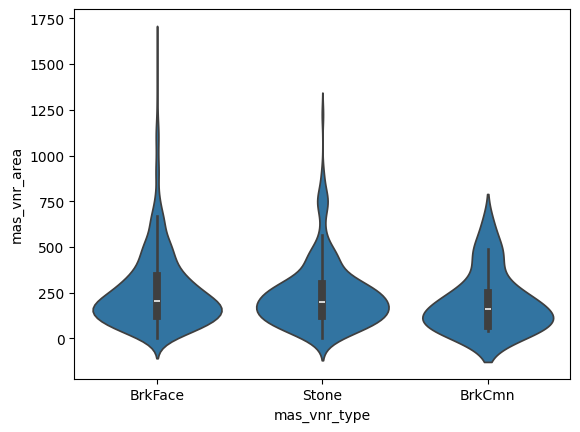

In [33]:
sns.violinplot(data=mas_vnr_df, x="mas_vnr_type", y="mas_vnr_area")

In [34]:
df.loc[area_l0_miss_idx]["mas_vnr_area"].describe()

count      8.000000
mean     178.750000
std      152.804029
min        1.000000
25%        1.000000
50%      241.500000
75%      294.000000
max      344.000000
Name: mas_vnr_area, dtype: float64

In [35]:
df.loc[area_l0_miss_idx,"mas_vnr_type"] = "BrkFace"

In [36]:
mas_vnr_mean = mas_vnr_df.groupby("mas_vnr_type").agg({"mas_vnr_area" : "mean"})

no_area_exist_type_idx = list(set(no_area_idx) - set(miss_idx))

mas_vnr_df.loc[no_area_exist_type_idx]



,mas_vnr_type,mas_vnr_area
688,BrkFace,0.0
1241,Stone,0.0
2319,BrkFace,0.0


In [37]:
mas_vnr_mean

,mas_vnr_area
mas_vnr_type,
BrkCmn,195.480000
BrkFace,261.672355
Stone,239.550201


In [38]:
df.loc[[688,2319],"mas_vnr_area"] = 261.672355

df.loc[[1241],"mas_vnr_area"] = 239.550201

In [39]:
df.loc[no_area_exist_type_idx]["mas_vnr_area"]

688     261.672355
1241    239.550201
2319    261.672355
Name: mas_vnr_area, dtype: float64

In [40]:
mas_vnr_df[mas_vnr_df["mas_vnr_area"] == 0]

,mas_vnr_type,mas_vnr_area
1,NaN,0.0
3,NaN,0.0
5,NaN,0.0
8,NaN,0.0
9,NaN,0.0
...,...,...
2913,NaN,0.0
2914,NaN,0.0
2915,NaN,0.0
2916,NaN,0.0


In [41]:
df["mas_vnr_area"].fillna(0, inplace=True)

C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\3819253587.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["mas_vnr_area"].fillna(0, inplace=True)


####  misc_feature

In [42]:
df[df["misc_feature"].isna() == False]["misc_val"].describe()

count      105.000000
mean      1251.057143
std       2178.648063
min          0.000000
25%        450.000000
50%        500.000000
75%       1200.000000
max      15500.000000
Name: misc_val, dtype: float64

In [43]:
# 가치는 0인데 misc_feature가 있는 데이터
df[(df["misc_feature"].isna() == False) & (df["misc_val"] == 0)]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1
873,874,40,RL,60.0,12144,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,Othr,0,9,2009,WD,Normal,133000.0,1940
1200,1201,20,RL,71.0,9353,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,Shed,0,7,2006,Oth,Abnorml,116050.0,1970
2431,2432,20,RL,NaN,7500,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,Shed,0,7,2007,WD,Normal,NaN,1950


In [44]:
# 가치는 0이 아닌데 misc_feature가 있는 데이터
df[(df["misc_feature"].isna()) & (df["misc_val"] != 0)]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1
2549,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,NaN,NaN,NaN,17000,10,2007,New,Partial,NaN,2000


In [45]:
df.groupby("misc_feature").agg({"misc_val" : ['mean', 'min', 'max', 'median', "count"]})

misc_val                           
                 mean   min    max  median count
misc_feature                                    
Gar2           8760.0  3000  15500  8300.0     5
Othr           3250.0     0   6500  3250.0     4
Shed            763.8     0   4500   500.0    95
TenC           2000.0  2000   2000  2000.0     1

In [46]:
idx = df[(df["misc_feature"].isna()) & (df["misc_val"] != 0)].index

df.loc[idx,"misc_feature"] = "Gar2"

 #### ms_zoning
 


In [47]:
df["ms_zoning"].value_counts()

ms_zoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: count, dtype: int64

In [48]:
# 지역 과 용도 상관분석

ct = pd.crosstab(index=df["neighborhood"],columns=df["ms_zoning"])

association(ct, method="cramer")

0.6555666546334852

In [49]:
# 주거유형 과 용도 상관분석

ct = pd.crosstab(index=df["house_style"],columns=df["ms_zoning"])

association(ct, method="cramer")

0.1816676108612403

In [50]:
# 주거스타일 과 용도 상관분석

ct = pd.crosstab(index=df["bldg_type"],columns=df["ms_zoning"])

association(ct, method="cramer")

0.19904286405461297

In [51]:
gbvc = df.groupby("neighborhood")["ms_zoning"].value_counts()
gbvc

neighborhood  ms_zoning
Blmngtn       RL            25
              RM             3
Blueste       RM            10
BrDale        RM            30
BrkSide       RM            65
              RL            43
ClearCr       RL            44
CollgCr       RL           253
              RM            14
Crawfor       RL            91
              RM            10
              RH             2
Edwards       RL           180
              RM            12
              RH             2
Gilbert       RL           165
IDOTRR        RM            68
              C (all)       22
MeadowV       RM            37
Mitchel       RL           104
              RM             9
NAmes         RL           436
              RH             7
NPkVill       RL            23
NWAmes        RL           131
NoRidge       RL            71
NridgHt       RL           165
              RM             1
OldTown       RM           198
              RL            39
              C (all)        2
SWISU         R

In [52]:
gbvc[("Blmngtn")][0]

C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\2917188931.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gbvc[("Blmngtn")][0]


25

In [53]:
idx = df[df["ms_zoning"].isna()].index

df.loc[idx, ["neighborhood","ms_zoning"]]

,neighborhood,ms_zoning
1915,IDOTRR,NaN
2216,IDOTRR,NaN
2250,IDOTRR,NaN
2904,Mitchel,NaN


In [54]:
df.loc[1915, "ms_zoning"] = "RM"
df.loc[2216, "ms_zoning"] = "RM"
df.loc[2250, "ms_zoning"] = "RM"
df.loc[2904, "ms_zoning"] = "RL"

#### sale_type

In [55]:
df[df["sale_type"].isna()][["neighborhood", "year_built_v1"]]

,neighborhood,year_built_v1
2489,Sawyer,1950


In [56]:
# 지역 과 용도 상관분석

ct = pd.crosstab(index=df["neighborhood"],columns=df["sale_type"])

association(ct, method="cramer")

0.18448524044518264

In [57]:
# 지역 과 용도 상관분석

ct = pd.crosstab(index=df["year_built_v1"],columns=df["sale_type"])

association(ct, method="cramer")

0.1897642930915875

In [58]:
# 방법이 두가지 기타로 넣거나 혹은 최빈값
df.loc[2489, "sale_type"] = "WD"

#### utilities

In [59]:
df["utilities"].value_counts()

utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64

In [60]:
idx = df[df["utilities"].isna()].index

df.loc[idx, "utilities"] = "AllPub"

In [61]:
for col in list(ca1_m_cols):
    if col == "alley":
        continue

    len_ = len(df[df[col].isna()])
    if len_ > 0:
        print(f"col : {col} // count : {len_} / {a_c}")

col : misc_feature // count : 2813 / 2919
col : garage_type // count : 157 / 2919
col : mas_vnr_type // count : 1758 / 2919


### category - 순서형(점수)

In [62]:
# 순서형 데이터 처리

ca2_m_cols = set(category2).intersection(set(missing_cols))
ca2_m_cols

{'bsmt_cond',
 'bsmt_exposure',
 'bsmt_fin_type1',
 'bsmt_fin_type2',
 'bsmt_qual',
 'electrical',
 'fence_qual',
 'fireplace_qual',
 'functional',
 'garage_cond',
 'garage_finish',
 'garage_qual',
 'kitchen_qual',
 'pool_qual'}

In [63]:
# 지하실 관련 컬럼의 결측치 확인

for b_c in bsmt_cols:
    m_c = len(df[df[b_c].isna()])
    print(f"컬럼명 : {[b_c]}결측 데이터 크기 / 전체 크기 : {m_c} / {len(df)}")

컬럼명 : ['bsmt_qual']결측 데이터 크기 / 전체 크기 : 81 / 2919
컬럼명 : ['bsmt_cond']결측 데이터 크기 / 전체 크기 : 82 / 2919
컬럼명 : ['bsmt_exposure']결측 데이터 크기 / 전체 크기 : 82 / 2919
컬럼명 : ['bsmt_fin_type1']결측 데이터 크기 / 전체 크기 : 79 / 2919
컬럼명 : ['bsmt_fin_type2']결측 데이터 크기 / 전체 크기 : 80 / 2919
컬럼명 : ['bsmt_full_bath']결측 데이터 크기 / 전체 크기 : 2 / 2919
컬럼명 : ['bsmt_half_bath']결측 데이터 크기 / 전체 크기 : 2 / 2919
컬럼명 : ['bsmt_fin_sf1']결측 데이터 크기 / 전체 크기 : 1 / 2919
컬럼명 : ['bsmt_fin_sf2']결측 데이터 크기 / 전체 크기 : 1 / 2919
컬럼명 : ['bsmt_un_sf']결측 데이터 크기 / 전체 크기 : 1 / 2919
컬럼명 : ['total_bsmt_sf']결측 데이터 크기 / 전체 크기 : 1 / 2919


In [64]:
# bsmt_cond와 bsmt_exposure의 결측치 비교

df[(df["bsmt_cond"].isna()) & (df["bsmt_exposure"].isna())][bsmt_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 17 to 2904
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bsmt_qual       0 non-null      object 
 1   bsmt_cond       0 non-null      object 
 2   bsmt_exposure   0 non-null      object 
 3   bsmt_fin_type1  0 non-null      object 
 4   bsmt_fin_type2  0 non-null      object 
 5   bsmt_full_bath  77 non-null     float64
 6   bsmt_half_bath  77 non-null     float64
 7   bsmt_fin_sf1    78 non-null     float64
 8   bsmt_fin_sf2    78 non-null     float64
 9   bsmt_un_sf      78 non-null     float64
 10  total_bsmt_sf   78 non-null     float64
dtypes: float64(6), object(5)
memory usage: 7.4+ KB


위의 79개의 index의 경우 지하실이 없다라고 할 수 있다. 그와 별개인 데이터를 알아보자.

In [65]:
non_bsmt_idx = df[(df["bsmt_cond"].isna()) & (df["bsmt_exposure"].isna())].index

non_bstm_cond_idx = df[df["bsmt_cond"].isna()].index

non_bstm_qual_idx = df[df["bsmt_qual"].isna()].index

non_bstm_exposure_idx = df[df["bsmt_exposure"].isna()].index

non_bstm_fin_type1_idx = df[df["bsmt_fin_type1"].isna()].index

non_bstm_fin_type2_idx = df[df["bsmt_fin_type2"].isna()].index


except_non_bsmt_idx = list(non_bstm_fin_type1_idx) + list(non_bstm_fin_type2_idx) + list(non_bstm_exposure_idx) + list(non_bstm_qual_idx) + list(non_bstm_cond_idx)

except_non_bsmt_idx = set(except_non_bsmt_idx)

except_non_bsmt_idx =  list(except_non_bsmt_idx - set(non_bsmt_idx))


df.loc[except_non_bsmt_idx, bsmt_cols]




,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,bsmt_full_bath,bsmt_half_bath,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_un_sf,total_bsmt_sf
2185,TA,NaN,No,BLQ,Unf,0.0,1.0,1033.0,0.0,94.0,1127.0
2218,NaN,TA,No,Unf,Unf,0.0,0.0,0.0,0.0,356.0,356.0
2217,NaN,Fa,No,Unf,Unf,0.0,0.0,0.0,0.0,173.0,173.0
2348,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,725.0,725.0
332,Gd,TA,No,GLQ,NaN,1.0,0.0,1124.0,479.0,1603.0,3206.0
1487,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,1595.0,1595.0
948,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,936.0,936.0
2040,Gd,NaN,Mn,GLQ,Rec,1.0,0.0,1044.0,382.0,0.0,1426.0
2524,TA,NaN,Av,ALQ,Unf,0.0,0.0,755.0,0.0,240.0,995.0


#### bsmt_fin_type2

In [66]:
df[(df["bsmt_fin_type1"] == "Unf") & (df["bsmt_fin_type2"] != "Unf")]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1


In [67]:
df[df["bsmt_fin_type1"] == "GLQ"]["bsmt_fin_type2"].value_counts()

bsmt_fin_type2
Unf    790
Rec     19
LwQ     17
ALQ     15
BLQ      7
Name: count, dtype: int64

In [68]:
df[(df["bsmt_fin_type2"] == "Unf") & (df["bsmt_fin_sf2"] != 0)][bsmt_cols]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,bsmt_full_bath,bsmt_half_bath,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_un_sf,total_bsmt_sf
2284,Gd,TA,No,GLQ,Unf,0.0,0.0,632.0,6.0,423.0,1061.0


In [69]:
# 전체가 0이 아닌 데이터 수집

except_non_bsmt_area = df[df["total_bsmt_sf"] > 0]

except_non_bsmt_area

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,2000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1970
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,2000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1910
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,1970
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,1970
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,1960
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,1990


In [70]:
except_non_bsmt_area["bsmt_fin_type1"].value_counts()

bsmt_fin_type1
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: count, dtype: int64

<Axes: xlabel='bsmt_fin_type1', ylabel='bsmt_fin_sf1'>

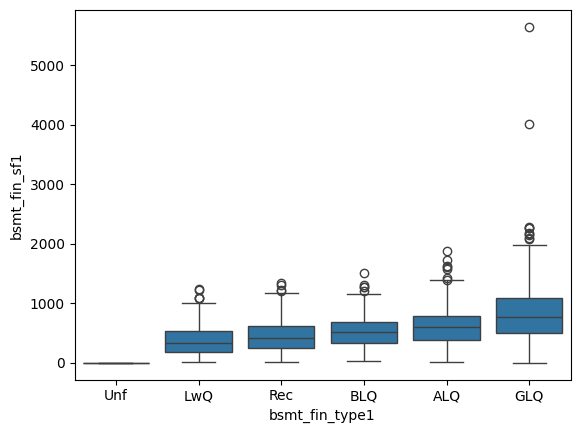

In [71]:
# 이상치 포함

sns.boxplot(data=except_non_bsmt_area, x="bsmt_fin_type1", y="bsmt_fin_sf1", order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"])

<Axes: xlabel='bsmt_fin_type1', ylabel='bsmt_fin_sf1'>

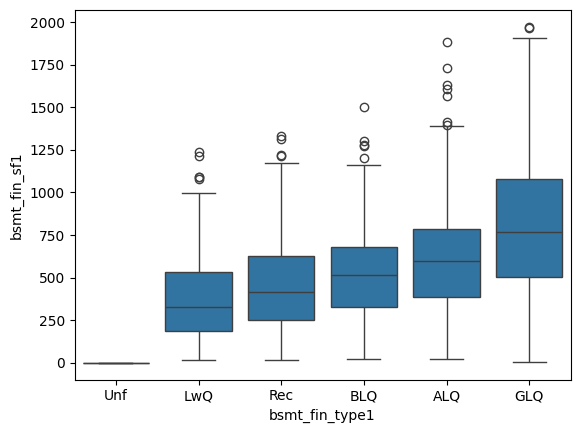

In [72]:
# 이상치 제거거

sns.boxplot(data=except_non_bsmt_area[except_non_bsmt_area["bsmt_fin_sf1"] <= 2000], x="bsmt_fin_type1", y="bsmt_fin_sf1", order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"])

<Axes: xlabel='bsmt_fin_type1', ylabel='bsmt_fin_sf1'>

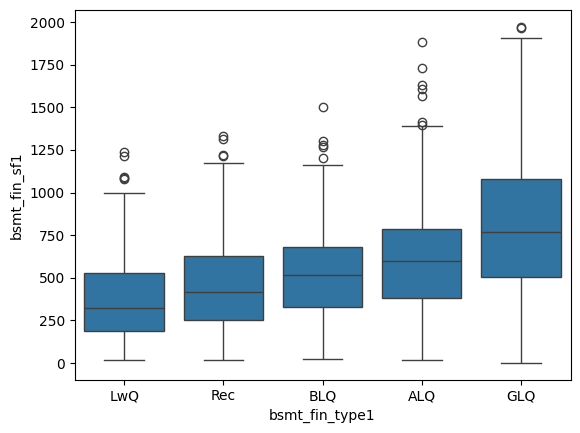

In [73]:
# 이상치 제거

sns.boxplot(data=except_non_bsmt_area[except_non_bsmt_area["bsmt_fin_sf1"] <= 2000], x="bsmt_fin_type1", y="bsmt_fin_sf1", order=["LwQ", "Rec", "BLQ", "ALQ", "GLQ"])

<Axes: xlabel='bsmt_fin_type1', ylabel='bsmt_fin_sf1'>

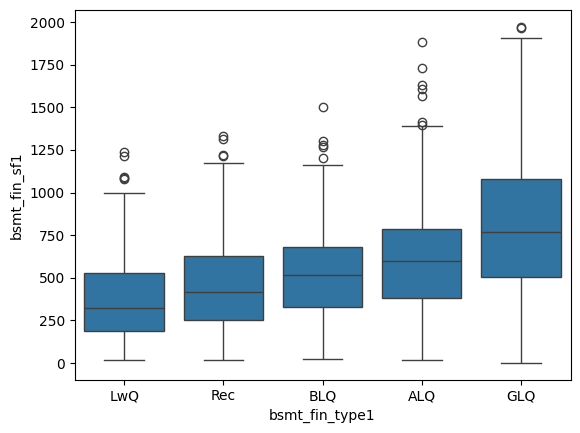

In [74]:

exper_df = df[["bsmt_fin_type1", "bsmt_fin_sf1"]]

exper_df = exper_df[(exper_df["bsmt_fin_sf1"] > 0) & (exper_df["bsmt_fin_sf1"] <= 2000)]

exper_df[exper_df["bsmt_fin_type1"] != "Unf"]


# 이상치 제거

sns.boxplot(data=exper_df, x="bsmt_fin_type1", y="bsmt_fin_sf1", order=["LwQ", "Rec", "BLQ", "ALQ", "GLQ"])


In [75]:
# 상관계수 측정

import scipy.stats


dict_bsmt_type = {
    "GLQ": 5,
    "ALQ": 4,
    "BLQ": 3,
    "Rec": 2,
    "LwQ": 1
}

exper_df["bsmt_fin_type1"] = exper_df["bsmt_fin_type1"].map(dict_bsmt_type)

print(f"스피어만 상관계수 : {scipy.stats.spearmanr(exper_df['bsmt_fin_type1'], exper_df['bsmt_fin_sf1'])}")
print(f"켄달타우 상관계수 : {scipy.stats.kendalltau(exper_df['bsmt_fin_type1'], exper_df['bsmt_fin_sf1'])}")


스피어만 상관계수 : SignificanceResult(statistic=0.3750937898795017, pvalue=3.82719642236355e-67)
켄달타우 상관계수 : SignificanceResult(statistic=0.2912394000315617, pvalue=1.1507144640938362e-67)


<Axes: xlabel='bsmt_fin_type2', ylabel='bsmt_fin_sf2'>

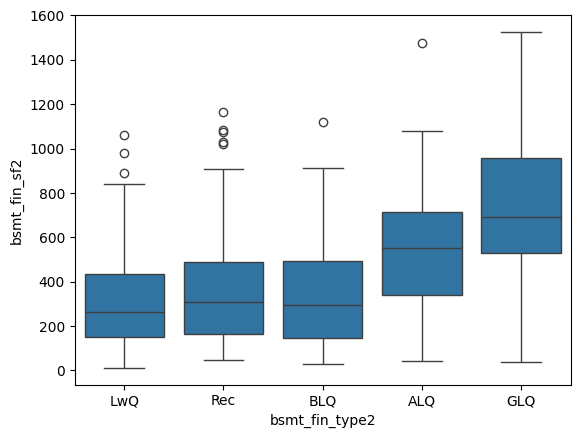

In [76]:

exper_df = df[["bsmt_fin_type2", "bsmt_fin_sf2"]]

exper_df = exper_df[(exper_df["bsmt_fin_sf2"] > 0) & (exper_df["bsmt_fin_sf2"] <= 2000)]

exper_df = exper_df[exper_df["bsmt_fin_type2"] != "Unf"]

exper_df = exper_df[exper_df["bsmt_fin_type2"].isna() == False]


# 이상치 제거

sns.boxplot(data=exper_df, x="bsmt_fin_type2", y="bsmt_fin_sf2", order=["LwQ", "Rec", "BLQ", "ALQ", "GLQ"])


In [77]:
# 상관계수 측정

dict_bsmt_type = {
    "GLQ": 5,
    "ALQ": 4,
    "BLQ": 3,
    "Rec": 2,
    "LwQ": 1
}

exper_df["bsmt_fin_type2"] = exper_df["bsmt_fin_type2"].map(dict_bsmt_type)

print(f"스피어만 상관계수 : {scipy.stats.spearmanr(exper_df['bsmt_fin_type2'], exper_df['bsmt_fin_sf2'])}")
print(f"켄달타우 상관계수 : {scipy.stats.kendalltau(exper_df['bsmt_fin_type2'], exper_df['bsmt_fin_sf2'])}")


스피어만 상관계수 : SignificanceResult(statistic=0.33751434637038474, pvalue=1.2255708227566859e-10)
켄달타우 상관계수 : SignificanceResult(statistic=0.25381538007677523, pvalue=1.8198782729519902e-10)


In [78]:
# type2의 결측치에 대해 면적은 479이다 그러므로 가장 가까운 ALQ로 수정한다.

miss_idx = list(set(non_bstm_fin_type2_idx) - set(non_bsmt_idx)) 

df.loc[miss_idx, "bsmt_fin_type2"] = "ALQ"

#### bsmt_exposure

In [79]:
df[(df["bsmt_fin_type1"] == "Unf") & (df["bsmt_fin_type2"] == "Unf")]["bsmt_exposure"]

8       No
13      Av
15      No
20      Av
21      No
        ..
2897    Mn
2898    No
2906    Mn
2913    No
2914    No
Name: bsmt_exposure, Length: 851, dtype: object

In [80]:
df[(df["bsmt_fin_type1"] == "Unf") & (df["bsmt_fin_type2"] == "Unf")]["bsmt_exposure"].value_counts()

bsmt_exposure
No    686
Av     83
Mn     57
Gd     22
Name: count, dtype: int64

<Axes: xlabel='bsmt_exposure', ylabel='count'>

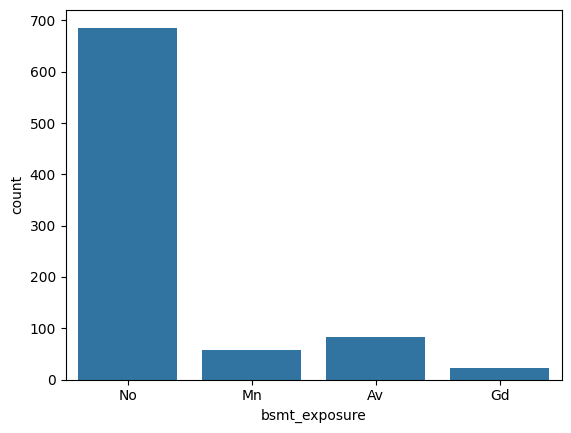

In [81]:
vc = df[(df["bsmt_fin_type1"] == "Unf") & (df["bsmt_fin_type2"] == "Unf")]["bsmt_exposure"].value_counts()

vc = pd.DataFrame(vc)

sns.barplot(vc, x=vc.index,y=vc["count"], order=["No", "Mn", "Av", "Gd"])

<Axes: xlabel='bsmt_exposure', ylabel='bsmt_un_sf'>

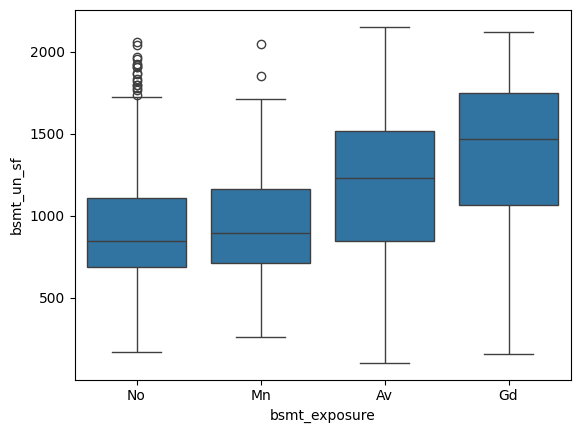

In [82]:
e_usf_tst = df[(df["bsmt_un_sf"] == df["total_bsmt_sf"]) & df["total_bsmt_sf"] > 0]

sns.boxplot(data=e_usf_tst,x="bsmt_exposure", y="bsmt_un_sf", order=["No", "Mn", "Av", "Gd"])

In [83]:
miss_idx = list(set(non_bstm_exposure_idx) - set(non_bsmt_idx))

df.loc[miss_idx, "bsmt_exposure"] = "No"

#### bsmt_qual

In [84]:
# bsmt_qual 또한 Un_sf == total_sf인 곳들이다.
df[(df["bsmt_un_sf"] == df["total_bsmt_sf"]) & df["total_bsmt_sf"] > 0]


,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900.0,1930
13,14,20,RL,91.0,10652,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,New,Partial,279500.0,2000
15,16,45,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,NaN,0,7,2007,WD,Normal,132000.0,1920
20,21,60,RL,101.0,14215,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,11,2006,New,Partial,325300.0,2000
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,...,NaN,GdPrv,NaN,0,6,2007,WD,Normal,139400.0,1930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,2898,90,RL,65.0,8385,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,10,2006,WD,Normal,NaN,1970
2898,2899,20,RL,70.0,9116,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2006,WD,Normal,NaN,2000
2906,2907,160,RM,41.0,2665,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2006,WD,Normal,NaN,1970
2913,2914,160,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,NaN,0,6,2006,WD,Normal,NaN,1970


In [85]:
vc = df[(df["bsmt_un_sf"] == df["total_bsmt_sf"]) & df["total_bsmt_sf"] > 0]["bsmt_qual"].value_counts()

vc = pd.DataFrame(vc)

vc

,count
bsmt_qual,
TA,369
Gd,364
Fa,60
Ex,56


<Axes: xlabel='bsmt_qual', ylabel='count'>

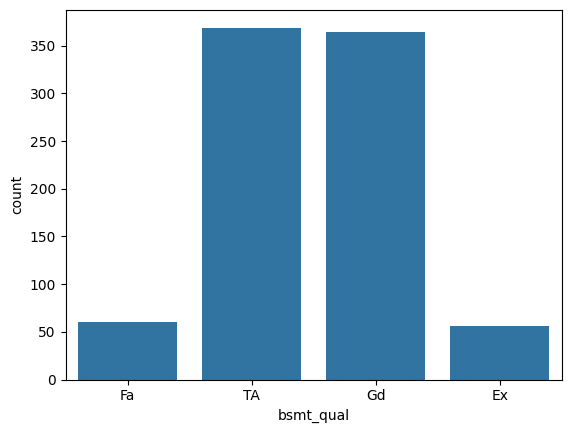

In [86]:
sns.barplot(data=vc,x=vc.index, y=vc["count"], order=["Fa", "TA", "Gd", "Ex"])

<Axes: xlabel='bsmt_qual', ylabel='bsmt_un_sf'>

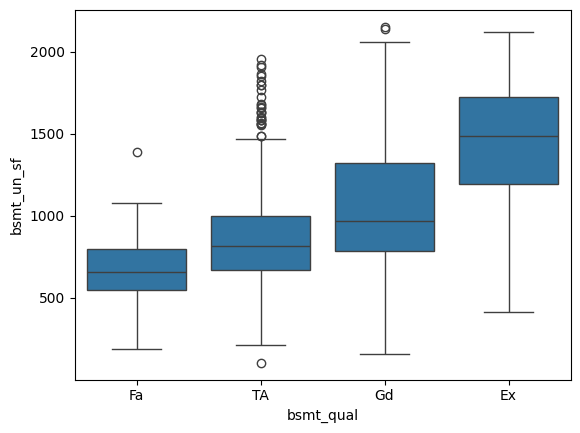

In [87]:
e_usf_tst = df[(df["bsmt_un_sf"] == df["total_bsmt_sf"]) & df["total_bsmt_sf"] > 0]

sns.boxplot(data=e_usf_tst,x="bsmt_qual", y="bsmt_un_sf", order=["Fa", "TA", "Gd", "Ex"])

In [88]:
# 결측치 TA로 채움

miss_idx = list(set(non_bstm_qual_idx) - set(non_bsmt_idx))

df.loc[miss_idx, "bsmt_qual"] = "TA"

#### bsmt_cond

In [89]:
# cond의 결측치가 있는 데이터는 전부 fin_sf1 >0 이다.

fin_sf1_up0 = df[df["bsmt_fin_sf1"] > 0]

fin_sf1_up0["bsmt_cond"].value_counts()

bsmt_cond
TA    1837
Gd      96
Fa      51
Po       2
Name: count, dtype: int64

<Axes: xlabel='bsmt_cond', ylabel='bsmt_fin_sf1'>

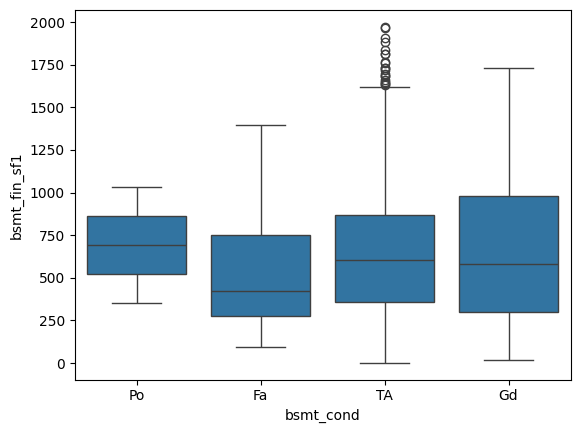

In [90]:
fin_sf1_up0 = fin_sf1_up0[fin_sf1_up0["bsmt_fin_sf1"] <= 2000]

sns.boxplot(data=fin_sf1_up0,x="bsmt_cond", y="bsmt_fin_sf1", order=["Po", "Fa", "TA", "Gd"])

In [91]:
# bsmt_cond 결측치는 TA로 채움

miss_idx = list(set(non_bstm_cond_idx) - set(non_bsmt_idx))

df.loc[miss_idx, "bsmt_cond"] = "TA"

#### 진짜 결측치 처리 완료



In [92]:
non_bsmt_idx = df[(df["bsmt_cond"].isna()) & (df["bsmt_exposure"].isna())].index

non_bstm_cond_idx = df[df["bsmt_cond"].isna()].index

non_bstm_qual_idx = df[df["bsmt_qual"].isna()].index

non_bstm_exposure_idx = df[df["bsmt_exposure"].isna()].index

non_bstm_fin_type1_idx = df[df["bsmt_fin_type1"].isna()].index

non_bstm_fin_type2_idx = df[df["bsmt_fin_type2"].isna()].index


except_non_bsmt_idx = list(non_bstm_fin_type1_idx) + list(non_bstm_fin_type2_idx) + list(non_bstm_exposure_idx) + list(non_bstm_qual_idx) + list(non_bstm_cond_idx)

except_non_bsmt_idx = set(except_non_bsmt_idx)

except_non_bsmt_idx =  list(except_non_bsmt_idx - set(non_bsmt_idx))


df.loc[except_non_bsmt_idx, bsmt_cols]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,bsmt_full_bath,bsmt_half_bath,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_un_sf,total_bsmt_sf


이제 부터는 지하실이 없는 데이터에 대해 손을 봐야한다.

#### 지하실이 없는 데이터 None으로 대체

In [93]:
df[bsmt_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bsmt_qual       2840 non-null   object 
 1   bsmt_cond       2840 non-null   object 
 2   bsmt_exposure   2840 non-null   object 
 3   bsmt_fin_type1  2840 non-null   object 
 4   bsmt_fin_type2  2840 non-null   object 
 5   bsmt_full_bath  2917 non-null   float64
 6   bsmt_half_bath  2917 non-null   float64
 7   bsmt_fin_sf1    2918 non-null   float64
 8   bsmt_fin_sf2    2918 non-null   float64
 9   bsmt_un_sf      2918 non-null   float64
 10  total_bsmt_sf   2918 non-null   float64
dtypes: float64(6), object(5)
memory usage: 251.0+ KB


In [94]:
# 일단 None으로 놓고 나중에 처리

bsmt_cols_ca2 = ['bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2']

for bc in bsmt_cols_ca2:
    df[bc] = df[bc].fillna("None")
    


In [95]:
df[bsmt_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bsmt_qual       2919 non-null   object 
 1   bsmt_cond       2919 non-null   object 
 2   bsmt_exposure   2919 non-null   object 
 3   bsmt_fin_type1  2919 non-null   object 
 4   bsmt_fin_type2  2919 non-null   object 
 5   bsmt_full_bath  2917 non-null   float64
 6   bsmt_half_bath  2917 non-null   float64
 7   bsmt_fin_sf1    2918 non-null   float64
 8   bsmt_fin_sf2    2918 non-null   float64
 9   bsmt_un_sf      2918 non-null   float64
 10  total_bsmt_sf   2918 non-null   float64
dtypes: float64(6), object(5)
memory usage: 251.0+ KB


#### bsmt_cond

지하실의 상태 평가가 좋을 수록 가격이 비싸지는가 ? => 양의 상관관계를 가지는가?


In [96]:
# 수치 크기 비교

bsmt_cond_df = train[["bsmt_cond", "sale_price"]]

bsmt_cond_df["bsmt_cond"].value_counts()

bsmt_cond
TA    1311
Gd      65
Fa      45
Po       2
Name: count, dtype: int64

C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\1340075849.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bsmt_cond_df["bsmt_cond"].fillna("None", inplace=True)
C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\1340075849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsmt_cond_df["bsmt_cond"].fillna("None", inplace=True)


<Axes: xlabel='bsmt_cond', ylabel='sale_price'>

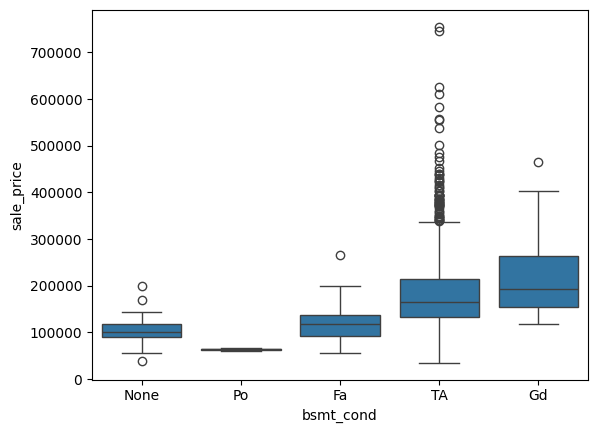

In [97]:
bsmt_cond_df["bsmt_cond"].fillna("None", inplace=True)
sns.boxplot(data=bsmt_cond_df, x="bsmt_cond", y="sale_price", order=["None","Po","Fa","TA","Gd"])

데이터의 결과를 봤을때 결측치를 Po보다 낮게 처리하는 것은 문제가 있다. 

첫번째 처리 방법 0 none Po -1 다음은 1부터 시작

#### electrical

In [98]:
# 결측치 확인

df[df["electrical"].isna()]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2008,WD,Normal,167500.0,2000


In [99]:
# 최빈값인 SBrkr로 대체

idx = df[df["electrical"].isna()].index

df.loc[idx, "electrical"] = "SBrkr"

#### fence_qual

In [100]:
non_fence = df[df["fence_qual"].isna()]

print(f"fence가 없는 주택의 개수 : {len(non_fence)}", end="\n\n")
print(f"fence가 있는 주택의 개수 : {len(df) - len(non_fence)}")


fence가 없는 주택의 개수 : 2348

fence가 있는 주택의 개수 : 571


In [101]:
# fence의 유무에 따른 가격 비교

fence_price = train[["fence_qual", "sale_price"]]

fence_price["fence_qual"] = fence_price["fence_qual"].fillna("None")

fence_price["is_fence"] = fence_price["fence_qual"].apply(is_exist_fence)

fence_price["is_fence"].value_counts()

C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\4039791621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fence_price["fence_qual"] = fence_price["fence_qual"].fillna("None")
C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\4039791621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fence_price["is_fence"] = fence_price["fence_qual"].apply(is_exist_fence)


is_fence
None     1179
Exist     281
Name: count, dtype: int64

<Axes: xlabel='is_fence', ylabel='sale_price'>

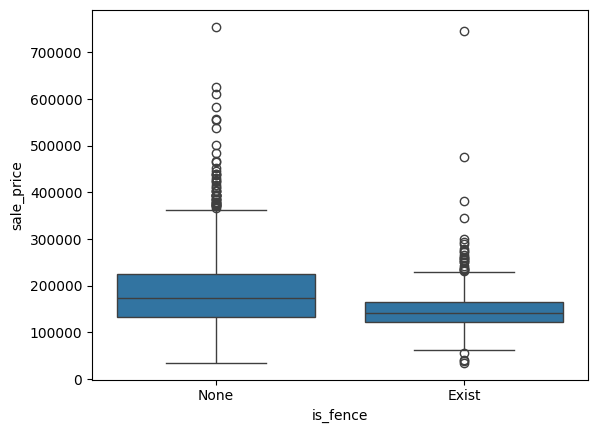

In [102]:
sns.boxplot(data=fence_price, x="is_fence", y="sale_price")

<Axes: xlabel='is_fence', ylabel='sale_price'>

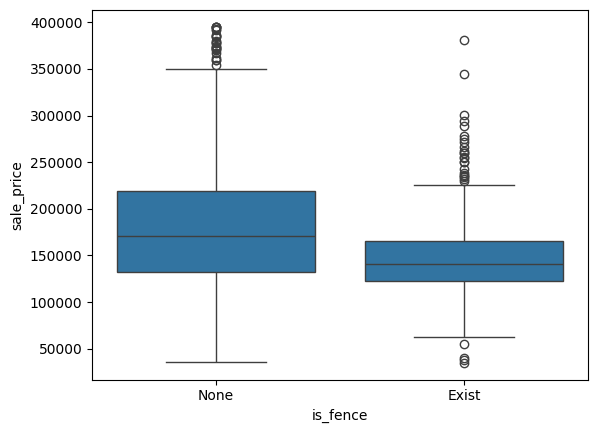

In [103]:
sns.boxplot(data=fence_price[fence_price["sale_price"] < 400000], x="is_fence", y="sale_price")

<Axes: xlabel='fence_qual', ylabel='sale_price'>

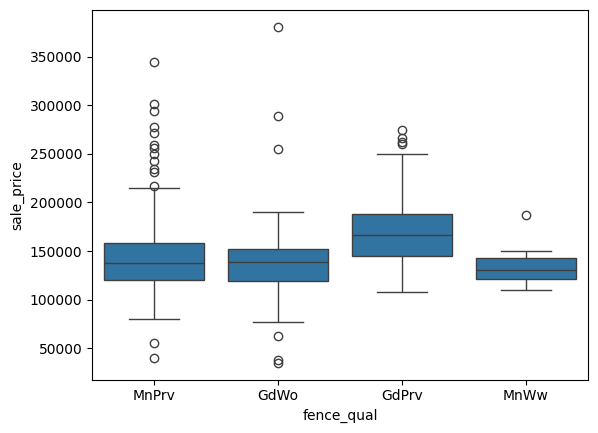

In [104]:
fence_price = fence_price[fence_price["sale_price"] < 400000]

sns.boxplot(data=fence_price[fence_price["is_fence"] == "Exist"], x="fence_qual", y="sale_price")

In [105]:
# 울타리와 관련해 있는지 없는지 여부 데이터만 남기고 삭제

df["fence_qual"] = df["fence_qual"].fillna("None")

df["is_fence"] = df["fence_qual"].apply(is_exist_fence)

df.drop(columns=["fence_qual"], inplace=True)


#### fireplace_qual


In [106]:
# fireplace_qual의 결측치

df[(df["fireplace_qual"].isna())&(df["fireplaces"]==0)] 

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1,is_fence
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500.0,2000,None
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,NaN,Shed,700,10,2009,WD,Normal,143000.0,1990,Exist
10,11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,129500.0,1960,None
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,144000.0,1960,None
15,16,45,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,7,2007,WD,Normal,132000.0,1920,Exist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2913,160,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,12,2006,WD,Abnorml,NaN,1970,None
2913,2914,160,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,6,2006,WD,Normal,NaN,1970,Exist
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,6,2006,WD,Normal,NaN,1970,None
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2006,WD,Abnorml,NaN,1970,None


C:\Users\kkj98\AppData\Local\Temp\ipykernel_14984\3664530101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireplace["fireplace_qual"] = fireplace["fireplace_qual"].fillna("None")


<Axes: xlabel='fireplace_qual', ylabel='sale_price'>

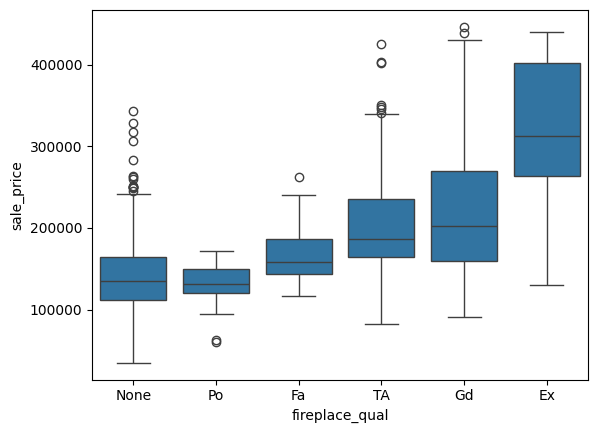

In [107]:
fireplace = train[["fireplaces","fireplace_qual", "sale_price"]]

fireplace["fireplace_qual"] = fireplace["fireplace_qual"].fillna("None")

sns.boxplot(data=fireplace[fireplace["sale_price"] < 450000],x="fireplace_qual",y="sale_price",order=["None", "Po", "Fa", "TA", "Gd", "Ex"])

In [108]:
df["fireplace_qual"].value_counts()

fireplace_qual
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64

In [595]:
# 결측값 처리 Po로 처리한다.

df["fireplace_qual"] = df["fireplace_qual"].fillna("Po")

#### functional


In [596]:
df["functional"] = df["functional"].fillna("Typ") 

<Axes: xlabel='functional', ylabel='sale_price'>

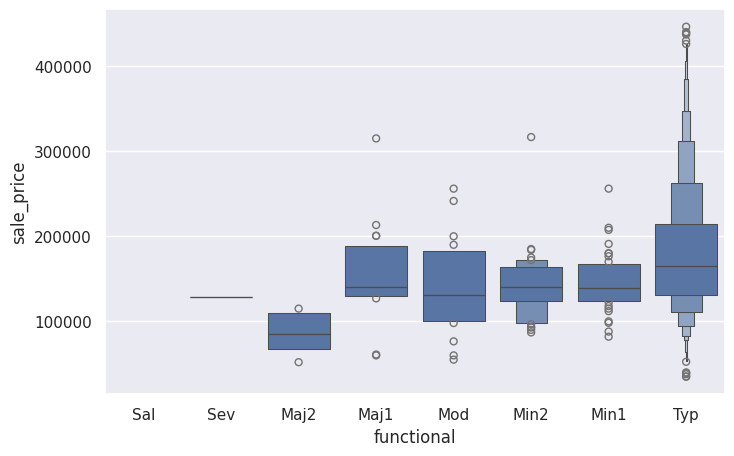

In [597]:
sns.boxenplot(data=train[train["sale_price"] <= 450000], x="functional", y="sale_price", order=["Sal","Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1","Typ"])

<Axes: xlabel='functional', ylabel='sale_price'>

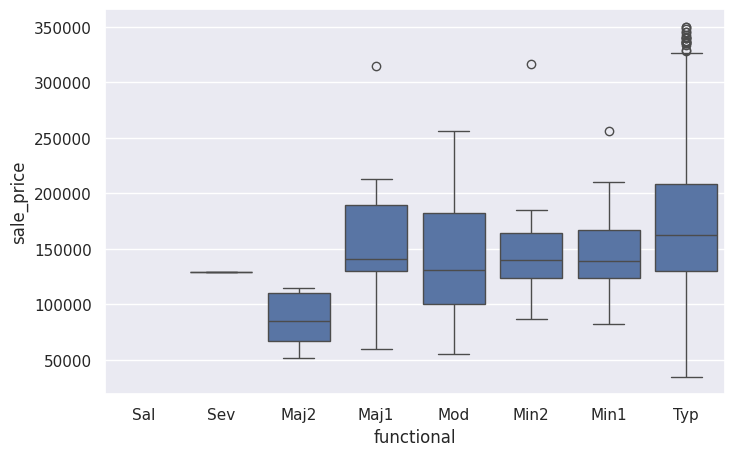

In [598]:
sns.boxplot(data=train[train["sale_price"] <= 350000], x="functional", y="sale_price", order=["Sal","Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1","Typ"])

In [599]:
functional_df = train[["functional", "sale_price"]]

functional_df["is_func"] = functional_df["functional"].apply(is_func)

functional_df["is_func"].value_counts()

/tmp/ipykernel_3473/2531439885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  functional_df["is_func"] = functional_df["functional"].apply(is_func)


is_func
0    1360
1     100
Name: count, dtype: int64

<Axes: xlabel='is_func', ylabel='sale_price'>

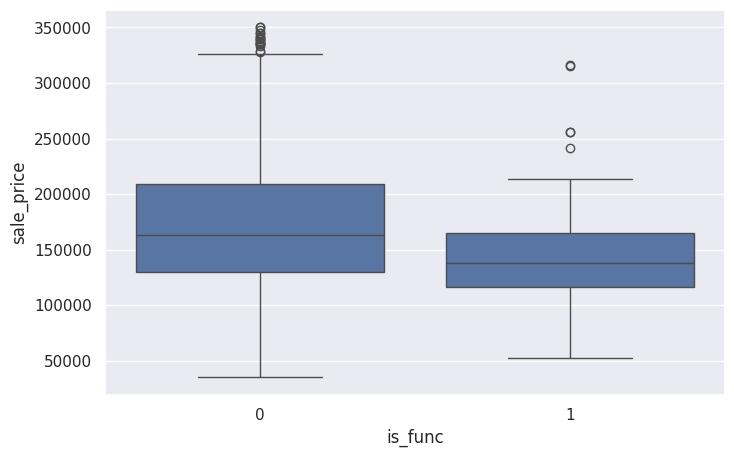

In [600]:
sns.boxplot(data=functional_df[functional_df["sale_price"] <= 350000], x="is_func", y="sale_price")

In [601]:
df["is_functional"] = df["functional"].apply(is_func)

df.drop(columns = ["functional"], inplace=True)

#### 차고관련 column

In [602]:
garage_cols = ["garage_type","garage_finish","garage_qual","garage_cond","garage_cars","garage_yr_built", "garage_area"]

df[garage_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   garage_type      2762 non-null   object 
 1   garage_finish    2760 non-null   object 
 2   garage_qual      2760 non-null   object 
 3   garage_cond      2760 non-null   object 
 4   garage_cars      2918 non-null   float64
 5   garage_yr_built  2760 non-null   float64
 6   garage_area      2918 non-null   float64
dtypes: float64(3), object(4)
memory usage: 159.8+ KB


In [603]:
for col in garage_cols:
    count = len(df[df[col].isna()])
    
    print(f"[{col}] 결측치 / 총데이터 : {count} / {len(df)}")

[garage_type] 결측치 / 총데이터 : 157 / 2919
[garage_finish] 결측치 / 총데이터 : 159 / 2919
[garage_qual] 결측치 / 총데이터 : 159 / 2919
[garage_cond] 결측치 / 총데이터 : 159 / 2919
[garage_cars] 결측치 / 총데이터 : 1 / 2919
[garage_yr_built] 결측치 / 총데이터 : 159 / 2919
[garage_area] 결측치 / 총데이터 : 1 / 2919


In [604]:
non_grg_idx = df[(df["garage_cond"].isna()) & (df["garage_type"].isna()) & (df["garage_cond"].isna())].index

df1 = df.loc[non_grg_idx]

df1[garage_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 39 to 2917
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   garage_type      0 non-null      object 
 1   garage_finish    0 non-null      object 
 2   garage_qual      0 non-null      object 
 3   garage_cond      0 non-null      object 
 4   garage_cars      157 non-null    float64
 5   garage_yr_built  0 non-null      float64
 6   garage_area      157 non-null    float64
dtypes: float64(3), object(4)
memory usage: 9.8+ KB


In [605]:
non_grg_idx = df[(df["garage_cond"].isna()) & (df["garage_type"].isna()) & (df["garage_cond"].isna())].index

non_grg_cond_idx = df[df["garage_cond"].isna()].index

non_grg_qual_idx = df[df["garage_qual"].isna()].index

non_grg_type_idx = df[df["garage_type"].isna()].index

non_grg_finish_idx = df[df["garage_finish"].isna()].index

non_grg_car_idx = df[df["garage_cars"].isna()].index

non_grg_area_idx = df[df["garage_area"].isna()].index


except_non_grg_idx = list(non_grg_finish_idx) + list(non_grg_cond_idx) + list(non_grg_qual_idx) + list(non_grg_type_idx) + list(non_grg_car_idx) + list(non_grg_area_idx)

except_non_grg_idx = set(except_non_grg_idx)

except_non_grg_idx =  list(except_non_grg_idx - set(non_grg_idx))


df.loc[except_non_grg_idx, garage_cols]




,garage_type,garage_finish,garage_qual,garage_cond,garage_cars,garage_yr_built,garage_area
2576,Detchd,NaN,NaN,NaN,NaN,NaN,NaN
2126,Detchd,NaN,NaN,NaN,1.0,NaN,360.0


In [606]:
# id 2576은 차고가 없는 것으로 추정

df.loc[2576,"garage_type"]= np.nan

In [607]:
## miss_idx = 2126


miss_idx = 2126

temp = df[(df["garage_type"] == "Detchd") & (df["garage_cars"] == 1) & (df["garage_area"]  <= 500)]


temp

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1,is_fence,is_functional
10,11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2008,WD,Normal,129500.0,1960,None,0
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,NaN,0,9,2008,WD,Normal,144000.0,1960,None,0
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,5,2008,WD,Normal,68500.0,1920,None,0
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,...,NaN,0,7,2008,WD,Normal,40000.0,1920,Exist,0
38,39,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,1,2010,WD,Abnorml,109000.0,1950,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,2880,50,RL,51.0,6191,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,11,2006,WD,Normal,NaN,1940,None,0
2880,2881,50,RL,66.0,21780,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,9,2006,WD,Normal,NaN,1920,Exist,1
2886,2887,30,RM,50.0,7288,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,8,2006,WD,AdjLand,NaN,1940,None,0
2889,2890,30,RM,50.0,7030,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,3,2006,WD,Normal,NaN,1920,Exist,0


In [608]:
# garage_finish

temp["garage_finish"].value_counts()


garage_finish
Unf    356
RFn      5
Fin      4
Name: count, dtype: int64

In [609]:
# garage_finish

df.loc[miss_idx, "garage_finish"] = "Unf"

In [610]:
# garage_qual

temp["garage_qual"].value_counts()

garage_qual
TA    290
Fa     68
Po      5
Gd      1
Ex      1
Name: count, dtype: int64

In [611]:
# garage_qual

df.loc[miss_idx, "garage_qual"] = "TA"

In [612]:
# garage_cond

temp["garage_cond"].value_counts()

garage_cond
TA    310
Fa     44
Po      9
Ex      1
Gd      1
Name: count, dtype: int64

In [613]:
# garage_cond

df.loc[miss_idx, "garage_cond"] = "TA"

In [614]:
non_grg_idx = df[(df["garage_cond"].isna()) & (df["garage_type"].isna()) & (df["garage_cond"].isna())].index

non_grg_cond_idx = df[df["garage_cond"].isna()].index

non_grg_qual_idx = df[df["garage_qual"].isna()].index

non_grg_type_idx = df[df["garage_type"].isna()].index

non_grg_finish_idx = df[df["garage_finish"].isna()].index

non_grg_car_idx = df[df["garage_cars"].isna()].index

non_grg_area_idx = df[df["garage_area"].isna()].index


except_non_grg_idx = list(non_grg_finish_idx) + list(non_grg_cond_idx) + list(non_grg_qual_idx) + list(non_grg_type_idx) + list(non_grg_car_idx) + list(non_grg_area_idx)

except_non_grg_idx = set(except_non_grg_idx)

except_non_grg_idx =  list(except_non_grg_idx - set(non_grg_idx))


df.loc[except_non_grg_idx, garage_cols]

,garage_type,garage_finish,garage_qual,garage_cond,garage_cars,garage_yr_built,garage_area


In [615]:
for col in garage_cols:
    count = len(df[df[col].isna()])
    
    print(f"[{col}] 결측치 / 총데이터 : {count} / {len(df)}")

[garage_type] 결측치 / 총데이터 : 158 / 2919
[garage_finish] 결측치 / 총데이터 : 158 / 2919
[garage_qual] 결측치 / 총데이터 : 158 / 2919
[garage_cond] 결측치 / 총데이터 : 158 / 2919
[garage_cars] 결측치 / 총데이터 : 1 / 2919
[garage_yr_built] 결측치 / 총데이터 : 159 / 2919
[garage_area] 결측치 / 총데이터 : 1 / 2919


##### garage_cond


#### kitchen_qual


In [616]:
df[df["kitchen_qual"].isna()]["kitchen"]

1555    1
Name: kitchen, dtype: int64

In [617]:
df[df["kitchen"] == 1]["kitchen_qual"].value_counts()

kitchen_qual
TA    1373
Gd    1146
Ex     205
Fa      61
Name: count, dtype: int64

In [618]:
miss_idx = df[df["kitchen_qual"].isna()].index

df.loc[miss_idx, "kitchen_qual"] = "TA"

#### pool_qual

In [619]:
df["pool_qual"].value_counts()

pool_qual
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

In [620]:
train[train["pool_qual"].isna() == False]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,pool_area,pool_qual,fence_qual,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000
1170,1171,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,...,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1386,1387,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000
1423,1424,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


In [621]:
# 수영장 관련 column = pool_area, pool_qual => is_pool로 변경 수영장이 있는지 없는지 여부 조사

df.drop(columns=["pool_qual"], inplace=True)

### 이산형 결측 데이터 처리

In [622]:
in1_m_cols = set(integer1).intersection(set(missing_cols))
in1_m_cols

{'bsmt_full_bath', 'bsmt_half_bath', 'garage_cars'}

In [623]:
bsmt_bath_cols = ['bsmt_full_bath', 'bsmt_half_bath']

df[df['bsmt_full_bath'].isna()][bsmt_cols]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,bsmt_full_bath,bsmt_half_bath,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_un_sf,total_bsmt_sf
2120,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2188,None,None,None,None,None,NaN,NaN,0.0,0.0,0.0,0.0


In [624]:
# 모두다 Nan이므로 없다고 추정

bsmt_in2_nan_idx = df[df['bsmt_full_bath'].isna()].index

df.loc[bsmt_in2_nan_idx, bsmt_bath_cols] = 0

In [625]:
# 차고 관련 데이터 처리

df[df["garage_cars"].isna()][garage_cols]

,garage_type,garage_finish,garage_qual,garage_cond,garage_cars,garage_yr_built,garage_area
2576,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [626]:
df["garage_cars"] = df["garage_cars"].fillna(0)

### 연속형 데이터 결측데이터 처리

In [627]:
in2_m_cols = set(integer2).intersection(set(missing_cols))
in2_m_cols

{'bsmt_fin_sf1',
 'bsmt_fin_sf2',
 'bsmt_un_sf',
 'garage_area',
 'lot_frontage',
 'mas_vnr_area',
 'total_bsmt_sf'}

#### 지하실관련 데이터 처리

In [628]:
# 지하실 관련 데이터 처리
bsmt_cols_in2 = ['bsmt_fin_sf1', 'bsmt_fin_sf2', 'bsmt_un_sf', 'total_bsmt_sf']

df[df["bsmt_fin_sf1"].isna()][bsmt_cols]


,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,bsmt_full_bath,bsmt_half_bath,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_un_sf,total_bsmt_sf
2120,None,None,None,None,None,0.0,0.0,NaN,NaN,NaN,NaN


In [629]:
# 결측치 처리 => 모두 0인 데이터로 대체

bsmt_in2_nan_idx = df[df["bsmt_fin_sf1"].isna()].index

df.loc[bsmt_in2_nan_idx, bsmt_cols_in2] = 0


In [630]:
# 

#### 차고 관련 데이터 처리

In [631]:
df[df["garage_area"].isna()][garage_cols]

,garage_type,garage_finish,garage_qual,garage_cond,garage_cars,garage_yr_built,garage_area
2576,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [632]:
df["garage_area"] = df["garage_area"].fillna(0)

#### pool_area

In [633]:
df["is_pool"] = df["pool_area"].apply(is_pool)

df.drop(columns=["pool_area"], inplace=True)

#### mas_vnr_area

In [634]:
df[df["mas_vnr_area"].isna()]["mas_vnr_type"]

Series([], Name: mas_vnr_type, dtype: object)

In [635]:
mean_ = df[df["mas_vnr_type"] == "BrkFace"]["mas_vnr_area"].mean()

df["mas_vnr_area"]= df["mas_vnr_area"].fillna(mean_)

In [636]:
df[df["mas_vnr_area"].isna()]["mas_vnr_type"]

Series([], Name: mas_vnr_type, dtype: object)

#### lot_frontage

In [637]:
vc = df[df["lot_frontage"].isna()]["neighborhood"].value_counts()

vc = pd.DataFrame(vc)

vc


,count
neighborhood,
NAmes,68
Gilbert,54
Sawyer,53
CollgCr,47
NWAmes,46
ClearCr,24
Mitchel,24
Somerst,20
Crawfor,20


In [638]:
gb = train.groupby("neighborhood").agg({"lot_frontage" : "mean"})
gb

,lot_frontage
neighborhood,
Blmngtn,47.142857
Blueste,24.000000
BrDale,21.562500
BrkSide,57.509804
ClearCr,83.461538
CollgCr,71.682540
Crawfor,71.804878
Edwards,68.217391
Gilbert,79.877551


In [639]:

miss_idx = df[df["lot_frontage"].isna()].index

for idx in miss_idx:
    df.loc[idx, "lot_frontage"] = gb.loc[df.loc[idx,"neighborhood"]].values[0]

df[df["lot_frontage"].isna()]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street_access,alley,lot_shape,land_contour,utilities,...,misc_val,mo_sold,yr_sold,sale_type,sale_cond,sale_price,year_built_v1,is_fence,is_functional,is_pool


### 시계열 데이터

In [640]:
miss_idx = 2126

df[df["garage_yr_built"].isna()][garage_cols]

,garage_type,garage_finish,garage_qual,garage_cond,garage_cars,garage_yr_built,garage_area
39,NaN,NaN,NaN,NaN,0.0,NaN,0.0
48,NaN,NaN,NaN,NaN,0.0,NaN,0.0
78,NaN,NaN,NaN,NaN,0.0,NaN,0.0
88,NaN,NaN,NaN,NaN,0.0,NaN,0.0
89,NaN,NaN,NaN,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...
2893,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2909,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2913,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2914,NaN,NaN,NaN,NaN,0.0,NaN,0.0


In [641]:
df.loc[miss_idx, time_data]

year_built         1910
year_remod_add     1983
garage_yr_built     NaN
mo_sold               9
yr_sold            2008
Name: 2126, dtype: object

In [642]:
temp["garage_yr_built"].describe()

count     365.000000
mean     1948.361644
std        23.261666
min      1895.000000
25%      1930.000000
50%      1947.000000
75%      1964.000000
max      2008.000000
Name: garage_yr_built, dtype: float64

In [643]:
df.loc[miss_idx, "garage_yr_built"] = 1947

### missing value 확인

In [644]:
# 전체 결측치 확인

count = 0
missing_cols= []
a_c = len(df)

for col in df.columns:
    len_ = len(df[df[col].isna()])
    if len_ > 0:
        print(f"col : {col} // count : {len_} / {a_c}")
        count += 1
        missing_cols.append(col)
        
    
print(f"결측치 columns의 개수 : {count}")

col : alley // count : 2721 / 2919
col : mas_vnr_type // count : 1758 / 2919
col : garage_type // count : 158 / 2919
col : garage_yr_built // count : 158 / 2919
col : garage_finish // count : 158 / 2919
col : garage_qual // count : 158 / 2919
col : garage_cond // count : 158 / 2919
col : misc_feature // count : 2813 / 2919
col : sale_price // count : 1459 / 2919
결측치 columns의 개수 : 9


## Outlier 처리

### 연속형 변수의 이상치

In [645]:
integer2 = ["lot_frontage","lot_area", "mas_vnr_area", "bsmt_fin_sf1", "bsmt_fin_sf2",
            "bsmt_un_sf", "total_bsmt_sf","1st_flr_sf","2nd_flr_sf","low_qual_fin_sf",
            "gr_liv_area","garage_area","wood_deck_sf","open_porch_sf",
            "enclosed_porch_sf","3ssn_porch_sf","screen_porch_sf"]

#### lot_frontage

In [646]:
df["lot_frontage"].describe()

count    2919.000000
mean       70.021155
std        21.711683
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

<Axes: xlabel='lot_frontage'>

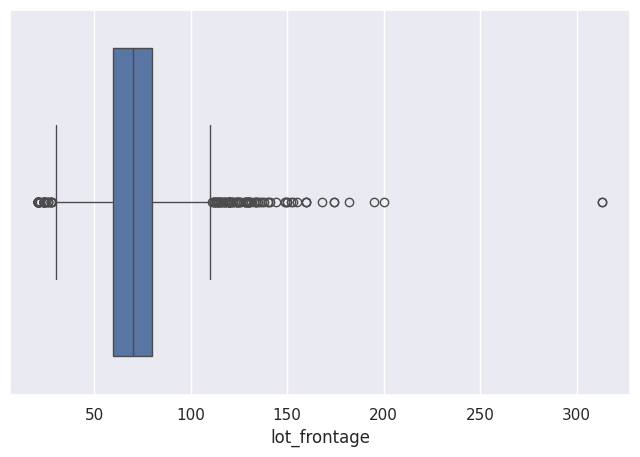

In [647]:
sns.boxplot(x=df["lot_frontage"])

In [648]:
# 300을 넘는 값이 두개개 존재

out_lot_f_idx = df[df["lot_frontage"] > 300].index

df.loc[out_lot_f_idx,["lot_frontage","sale_price"]]

,lot_frontage,sale_price
934,313.0,242000.0
1298,313.0,160000.0


<Axes: xlabel='lot_frontage'>

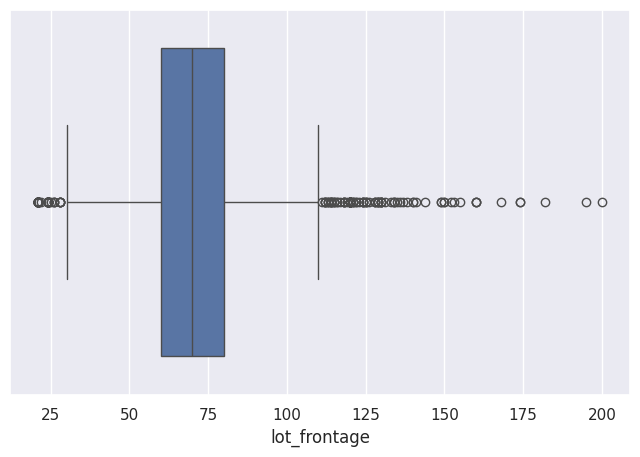

In [649]:
sns.boxplot(x=df[df["lot_frontage"] <= 200]["lot_frontage"])

<Axes: xlabel='lot_frontage', ylabel='sale_price'>

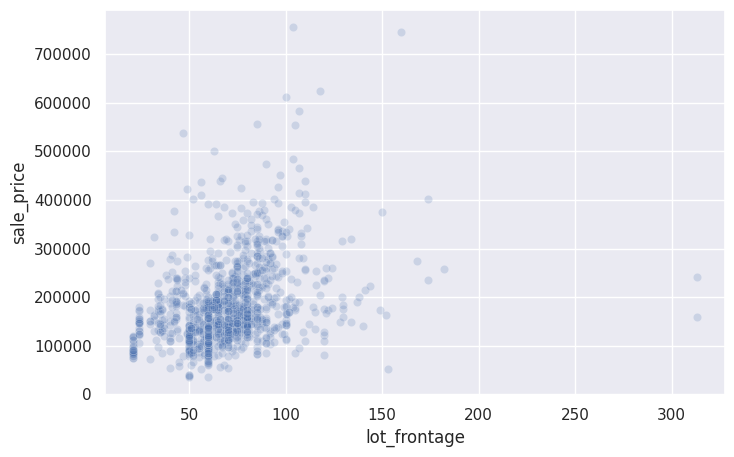

In [650]:
sns.scatterplot(data=train, x="lot_frontage", y="sale_price", alpha=0.2)

<Axes: xlabel='lot_frontage', ylabel='sale_price'>

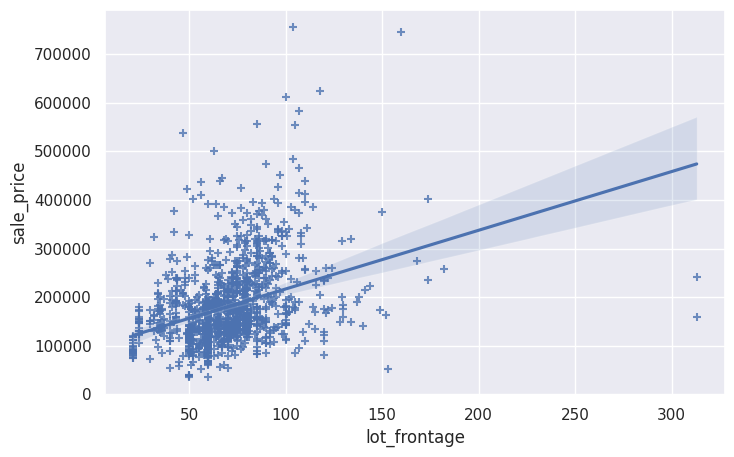

In [651]:
sns.regplot(data=train, x="lot_frontage", y="sale_price",marker="+")

In [652]:
out_lot_frontage_idx = df[df["lot_frontage"] > 200].index

df.loc[out_lot_frontage_idx, "lot_frontage"] = 200

#### lot_area

In [653]:
# describe()

df["lot_area"].describe()

count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
25%        7478.000000
50%        9453.000000
75%       11570.000000
max      215245.000000
Name: lot_area, dtype: float64

<Axes: xlabel='lot_area'>

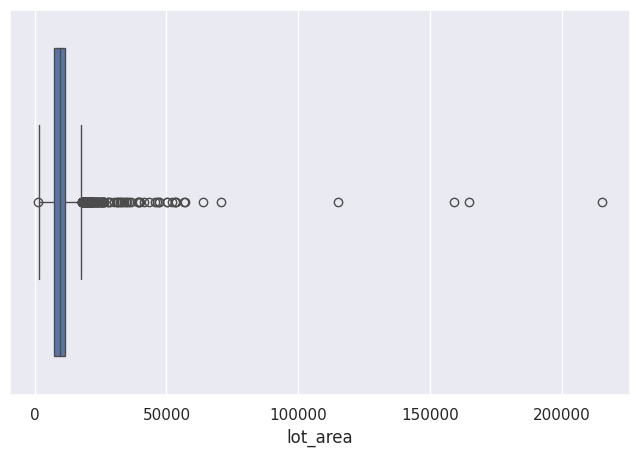

In [654]:
sns.boxplot(x=df["lot_area"])

결측치 개수 (100000이상) : 4


<Axes: xlabel='lot_area'>

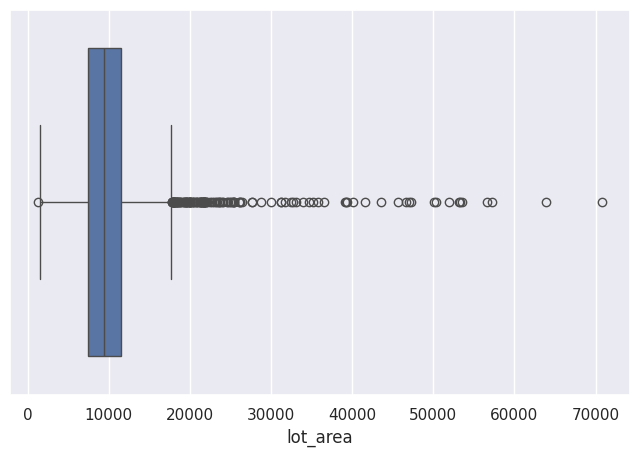

In [655]:
out_lot_a_idx = df[df['lot_area'] >= 100000].index

print(f"결측치 개수 (100000이상) : {len(df[df['lot_area'] >= 100000])}")

sns.boxplot(x=df[df["lot_area"] < 100000]["lot_area"])

결측치 개수 (20000이상) : 91


<Axes: xlabel='lot_area'>

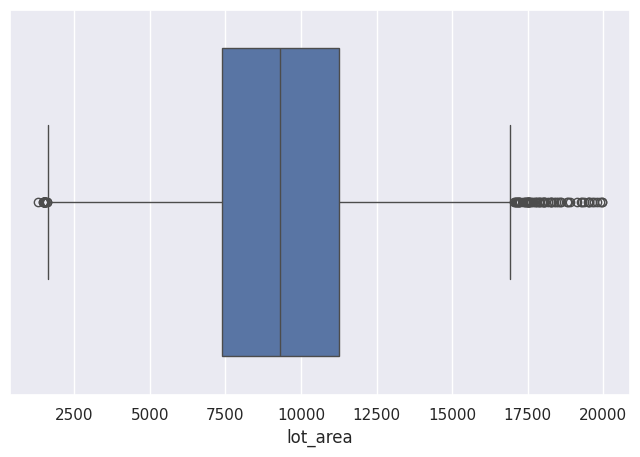

In [656]:
print(f"결측치 개수 (20000이상) : {len(df[df['lot_area'] >= 20000])}")

sns.boxplot(x=df[df["lot_area"] < 20000]["lot_area"])

<Axes: xlabel='lot_area', ylabel='sale_price'>

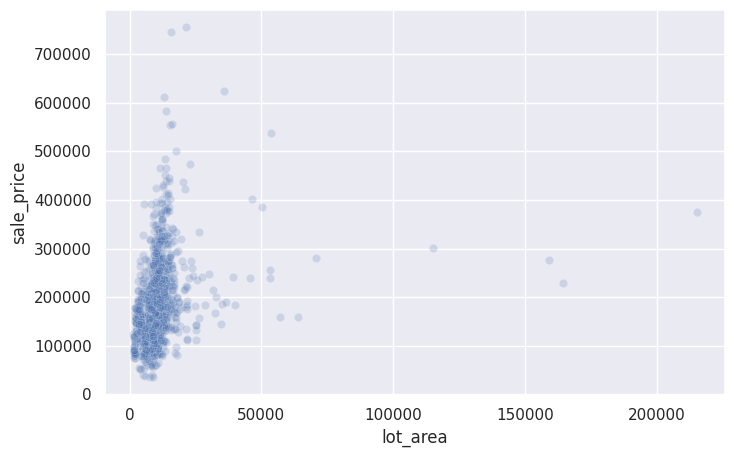

In [657]:
sns.scatterplot(data=train, x="lot_area", y="sale_price", alpha=0.2)

<Axes: xlabel='lot_area', ylabel='sale_price'>

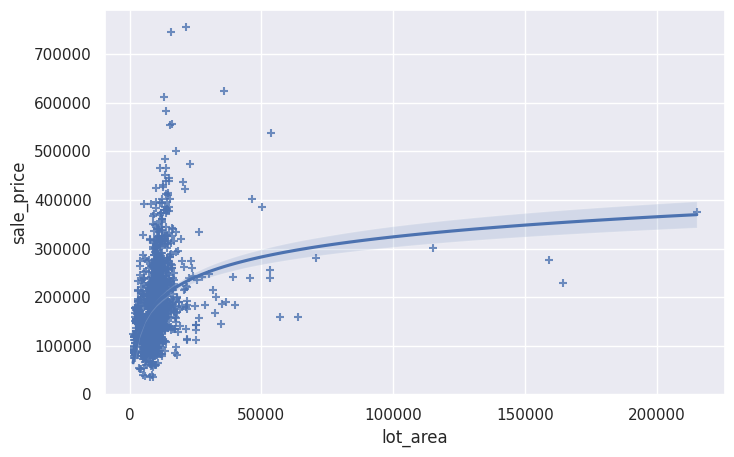

In [658]:
sns.regplot(data=train, x="lot_area", y="sale_price", marker="+", logx=True)

<Axes: xlabel='lot_area', ylabel='sale_price'>

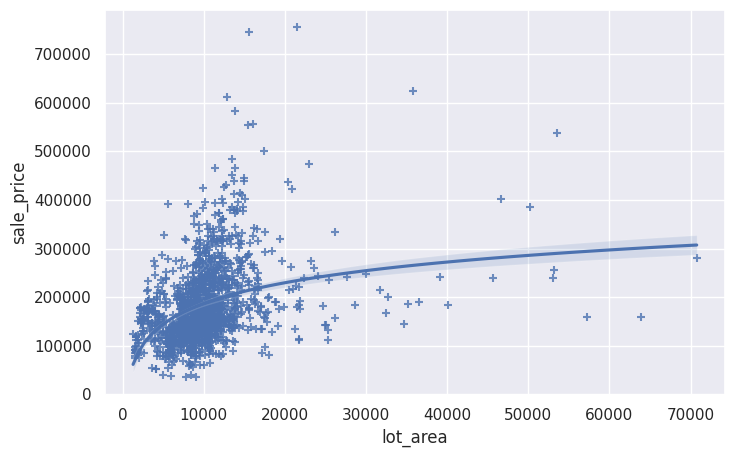

In [659]:
sns.regplot(data=train[train["lot_area"] < 100000], x="lot_area", y="sale_price", marker="+", logx=True)

<Axes: xlabel='lot_area', ylabel='sale_price'>

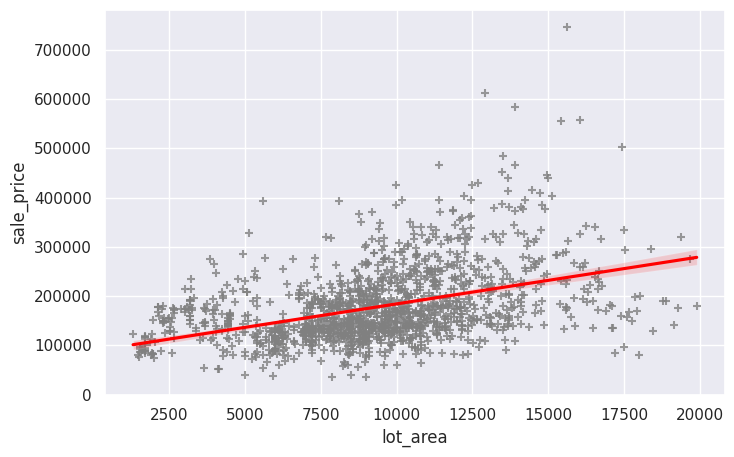

In [660]:
sns.regplot(data=train[train["lot_area"] < 20000], x="lot_area", y="sale_price", marker="+",
            line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})

In [661]:
out_lot_area_idx = df[df["lot_area"] > 50000].index

df.loc[out_lot_area_idx, "lot_area"] = 50000

#### mas_vnr_area

In [662]:
df["mas_vnr_area"].describe()

count    2919.000000
mean      101.657381
std       178.892341
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: mas_vnr_area, dtype: float64

In [663]:
df[df["mas_vnr_area"]>0]["mas_vnr_area"].describe()

count    1161.000000
mean      255.588195
std       202.795338
min         1.000000
25%       120.000000
50%       203.000000
75%       324.000000
max      1600.000000
Name: mas_vnr_area, dtype: float64

<Axes: xlabel='mas_vnr_area'>

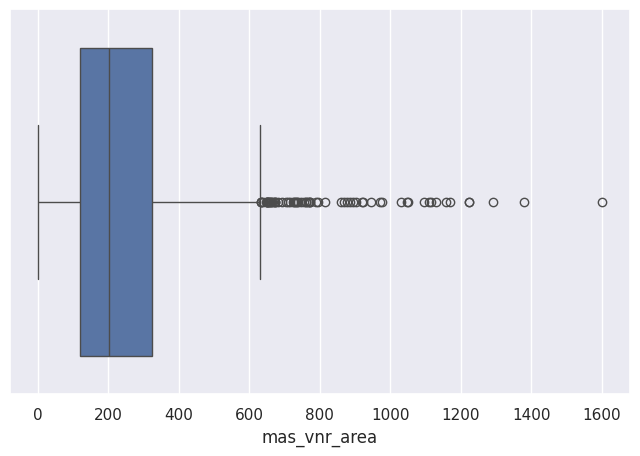

In [664]:
sns.boxplot(x=df[df["mas_vnr_area"]>0]["mas_vnr_area"])

1000 이상의 이상치 개수 : 14


<Axes: xlabel='mas_vnr_area'>

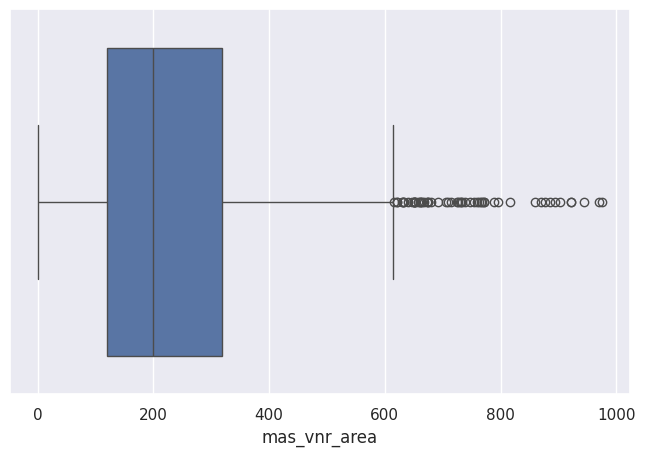

In [665]:
out_mva_idx = df[df['mas_vnr_area']>=1000].index

print(f"1000 이상의 이상치 개수 : {len(df[df['mas_vnr_area']>=1000])}")

sns.boxplot(x=df[(df["mas_vnr_area"]>0) &(df["mas_vnr_area"]<1000)]["mas_vnr_area"])

<Axes: xlabel='mas_vnr_area', ylabel='sale_price'>

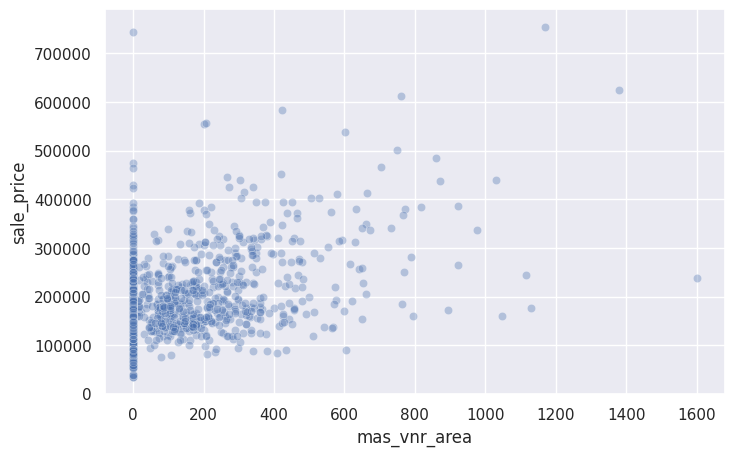

In [666]:
sns.scatterplot(data=train,
                x = "mas_vnr_area",
                y = "sale_price",
                alpha = 0.35)

<Axes: xlabel='mas_vnr_area', ylabel='sale_price'>

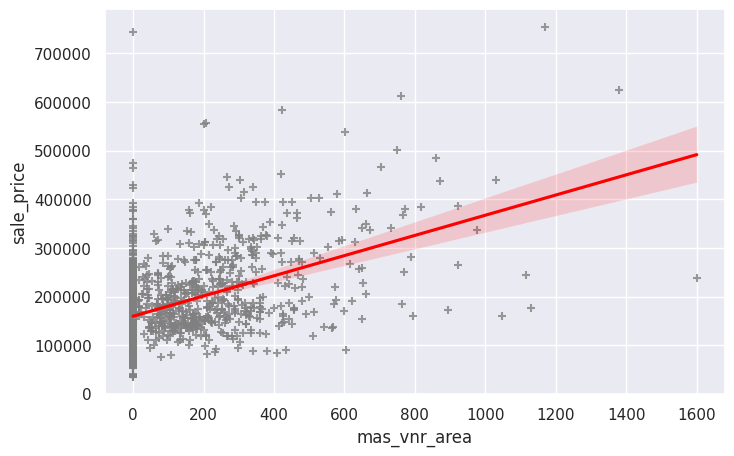

In [667]:
sns.regplot(data=train,
                x = "mas_vnr_area",
                y = "sale_price",
                marker="+",
                line_kws={'color': 'red'}, 
                scatter_kws={'color': 'grey'})

In [668]:
out_mas_vnr_area_idx = df[df["mas_vnr_area"] > 1200].index

df.loc[out_mas_vnr_area_idx, "mas_vnr_area"] = 1200

#### 지하실 관련 컬럼 이상치 확인

In [669]:
bsmt_in2_col = ["bsmt_fin_sf1", "bsmt_fin_sf2","bsmt_un_sf", "total_bsmt_sf"]

for col in bsmt_in2_col:
    print(df[col].describe())
    print("\n\n")



count    2919.000000
mean      441.272011
std       455.606014
min         0.000000
25%         0.000000
50%       368.000000
75%       733.000000
max      5644.000000
Name: bsmt_fin_sf1, dtype: float64



count    2919.000000
mean       49.565262
std       169.179104
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: bsmt_fin_sf2, dtype: float64



count    2919.000000
mean      560.579993
std       439.590889
min         0.000000
25%       220.000000
50%       467.000000
75%       805.000000
max      2336.000000
Name: bsmt_un_sf, dtype: float64



count    2919.000000
mean     1051.417266
std       441.120498
min         0.000000
25%       793.000000
50%       989.000000
75%      1302.000000
max      6110.000000
Name: total_bsmt_sf, dtype: float64





<Axes: xlabel='bsmt_fin_sf1'>

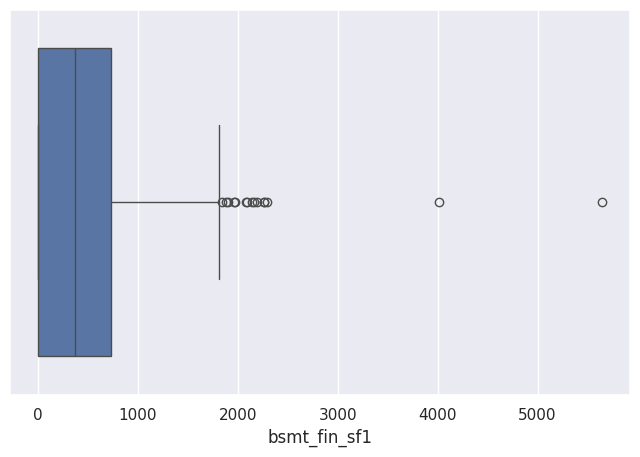

In [670]:
sns.boxplot(x = df["bsmt_fin_sf1"])




<Axes: xlabel='bsmt_fin_sf1', ylabel='sale_price'>

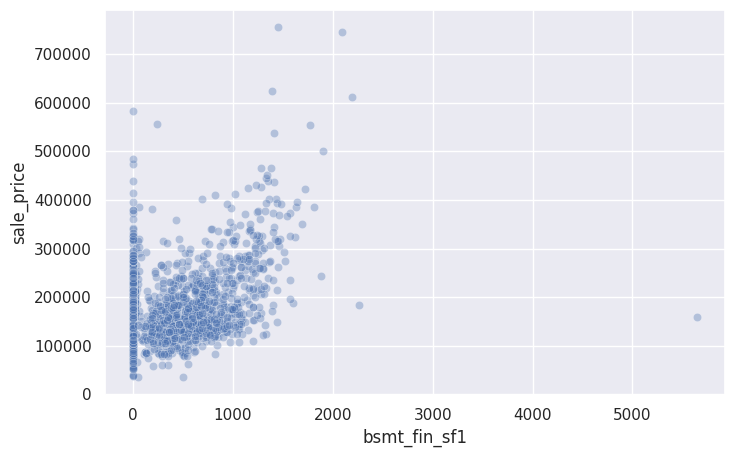

In [671]:
sns.scatterplot(data=train,
                x = "bsmt_fin_sf1",
                y = "sale_price",
                alpha = 0.35)

<Axes: xlabel='bsmt_fin_sf2'>

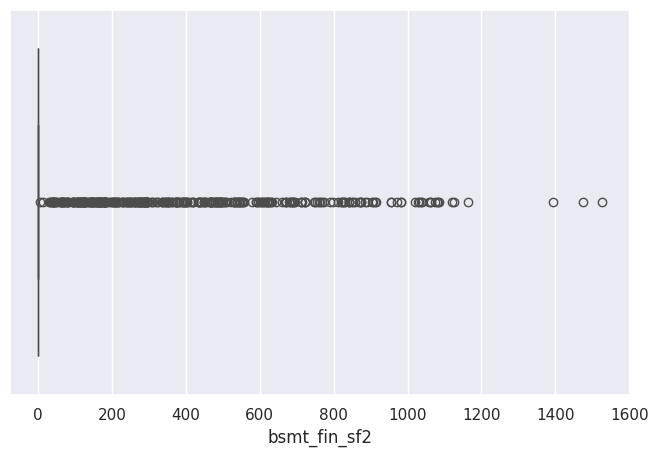

In [672]:
sns.boxplot(x = df["bsmt_fin_sf2"])


<Axes: xlabel='bsmt_fin_sf2', ylabel='sale_price'>

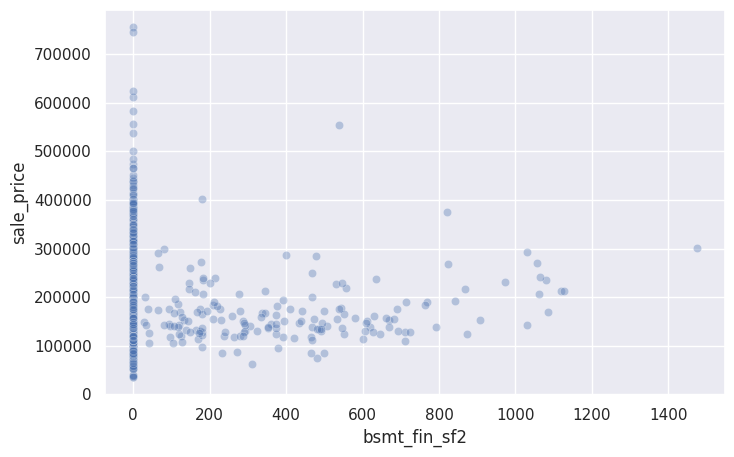

In [673]:
sns.scatterplot(data=train,
                x = "bsmt_fin_sf2",
                y = "sale_price",
                alpha = 0.35)

<Axes: xlabel='bsmt_un_sf'>

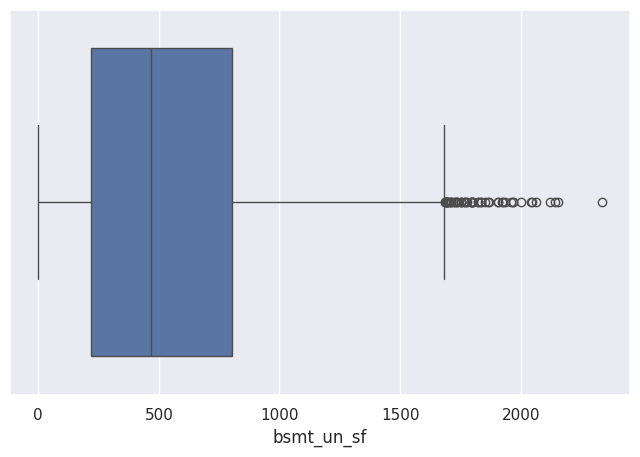

In [674]:
sns.boxplot(x = df["bsmt_un_sf"])




<Axes: xlabel='bsmt_un_sf', ylabel='sale_price'>

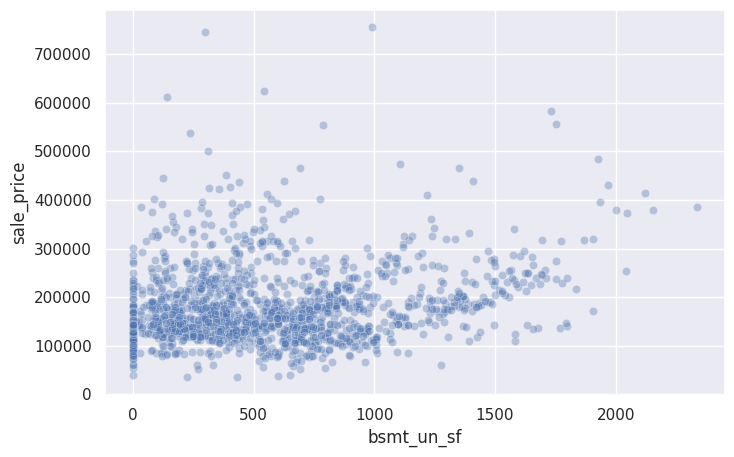

In [675]:
sns.scatterplot(data=train,
                x = "bsmt_un_sf",
                y = "sale_price",
                alpha = 0.35)

<Axes: xlabel='total_bsmt_sf'>

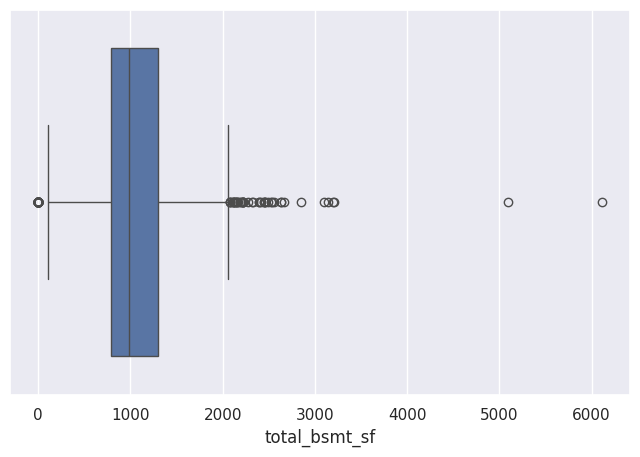

In [676]:
sns.boxplot(x = df["total_bsmt_sf"])


<Axes: xlabel='total_bsmt_sf', ylabel='sale_price'>

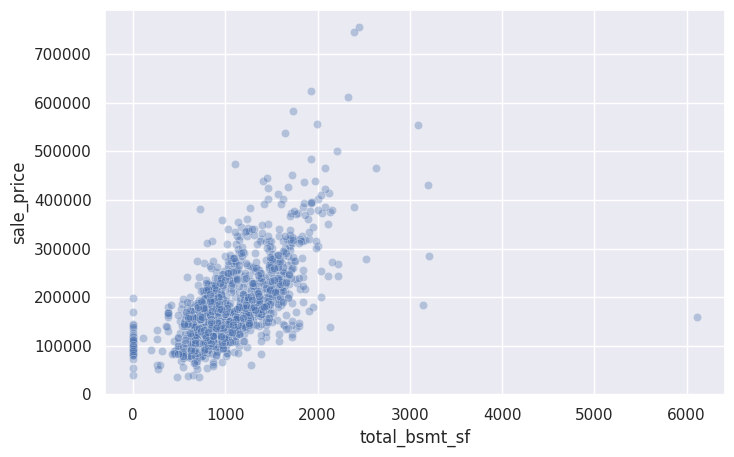

In [677]:
sns.scatterplot(data=train,
                x = "total_bsmt_sf",
                y = "sale_price",
                alpha = 0.35)

/tmp/ipykernel_3473/2661013647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["is_bsmt_2"] = train["bsmt_fin_sf2"].apply(lambda x : 1 if x > 0 else 0)


<Axes: xlabel='neighborhood', ylabel='sale_price'>

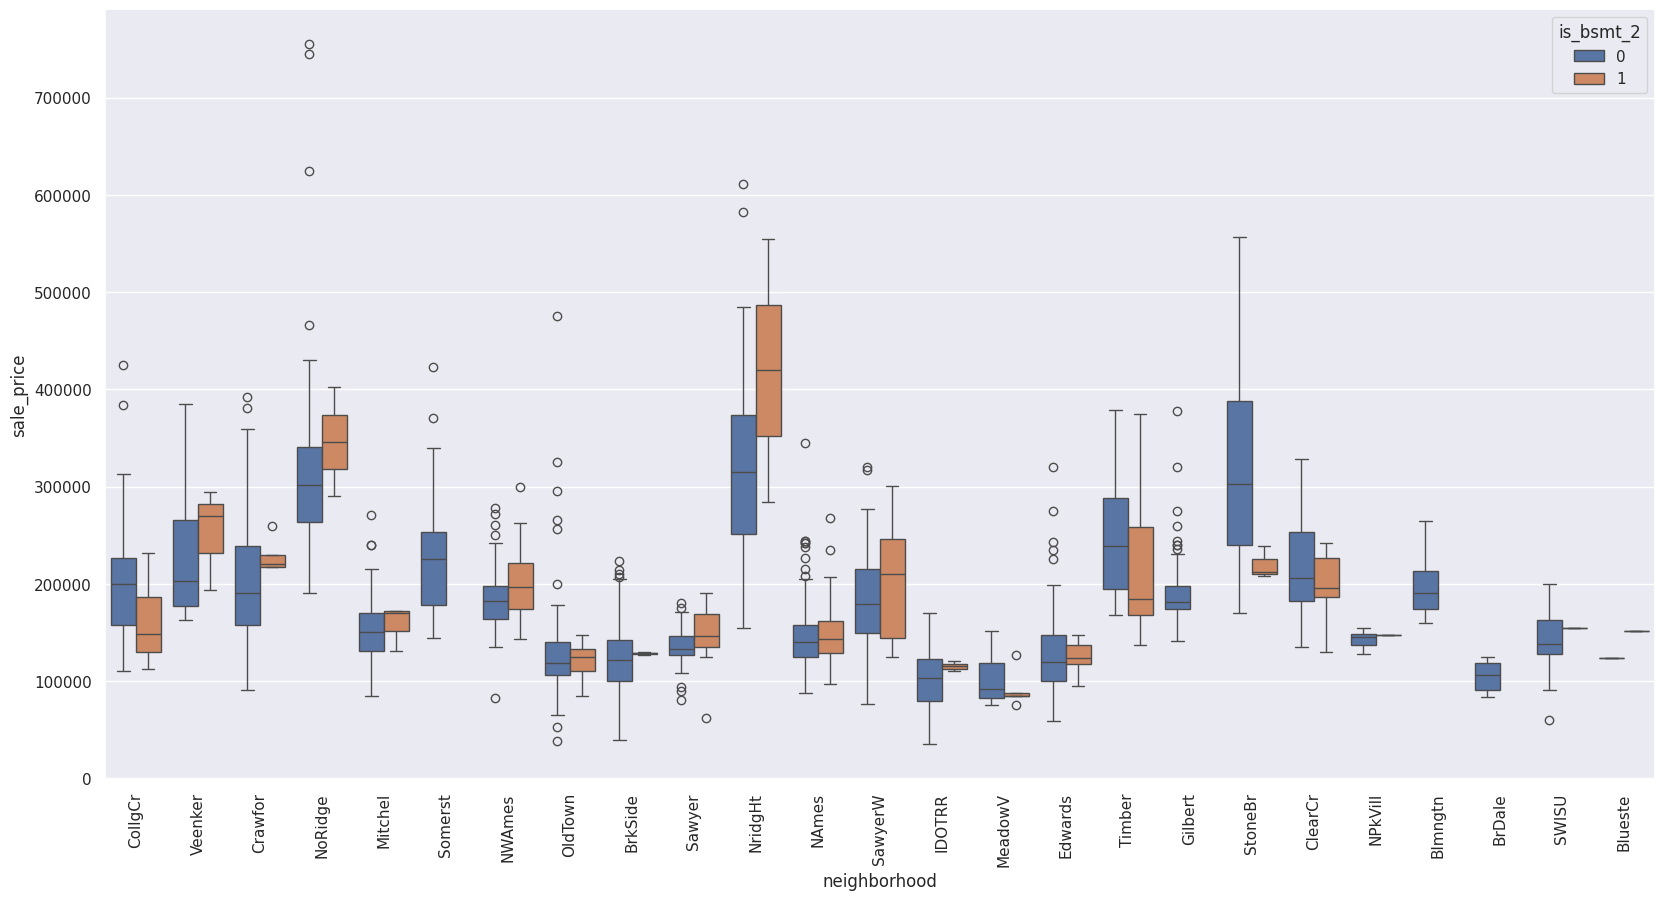

In [678]:
temp = train[bsmt_in2_col + ["neighborhood","sale_price"]]

temp["is_bsmt_2"] = train["bsmt_fin_sf2"].apply(lambda x : 1 if x > 0 else 0)

sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="is_bsmt_2")

fig.tick_params(axis='x', rotation=90)

fig


In [679]:
temp["is_bsmt_2"].value_counts()

is_bsmt_2
0    1293
1     167
Name: count, dtype: int64

In [680]:
out_tbsmt_idx = df[df["total_bsmt_sf"] > 3000].index

len(out_tbsmt_idx)

6

#### 지상층 관련 컬럼 이상치 확인

In [681]:
gr_sf_cols = ["1st_flr_sf","2nd_flr_sf","low_qual_fin_sf","gr_liv_area"]

for col in gr_sf_cols:
    print(df[col].describe(), end = "\n\n\n")

count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
25%       876.000000
50%      1082.000000
75%      1387.500000
max      5095.000000
Name: 1st_flr_sf, dtype: float64


count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
25%         0.000000
50%         0.000000
75%       704.000000
max      2065.000000
Name: 2nd_flr_sf, dtype: float64


count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1064.000000
Name: low_qual_fin_sf, dtype: float64


count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
25%      1126.000000
50%      1444.000000
75%      1743.500000
max      5642.000000
Name: gr_liv_area, dtype: float64




/tmp/ipykernel_3473/3627248093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["is_2f"] = train["2nd_flr_sf"].apply(lambda x : 1 if x > 0 else 0)


<Axes: xlabel='neighborhood', ylabel='sale_price'>

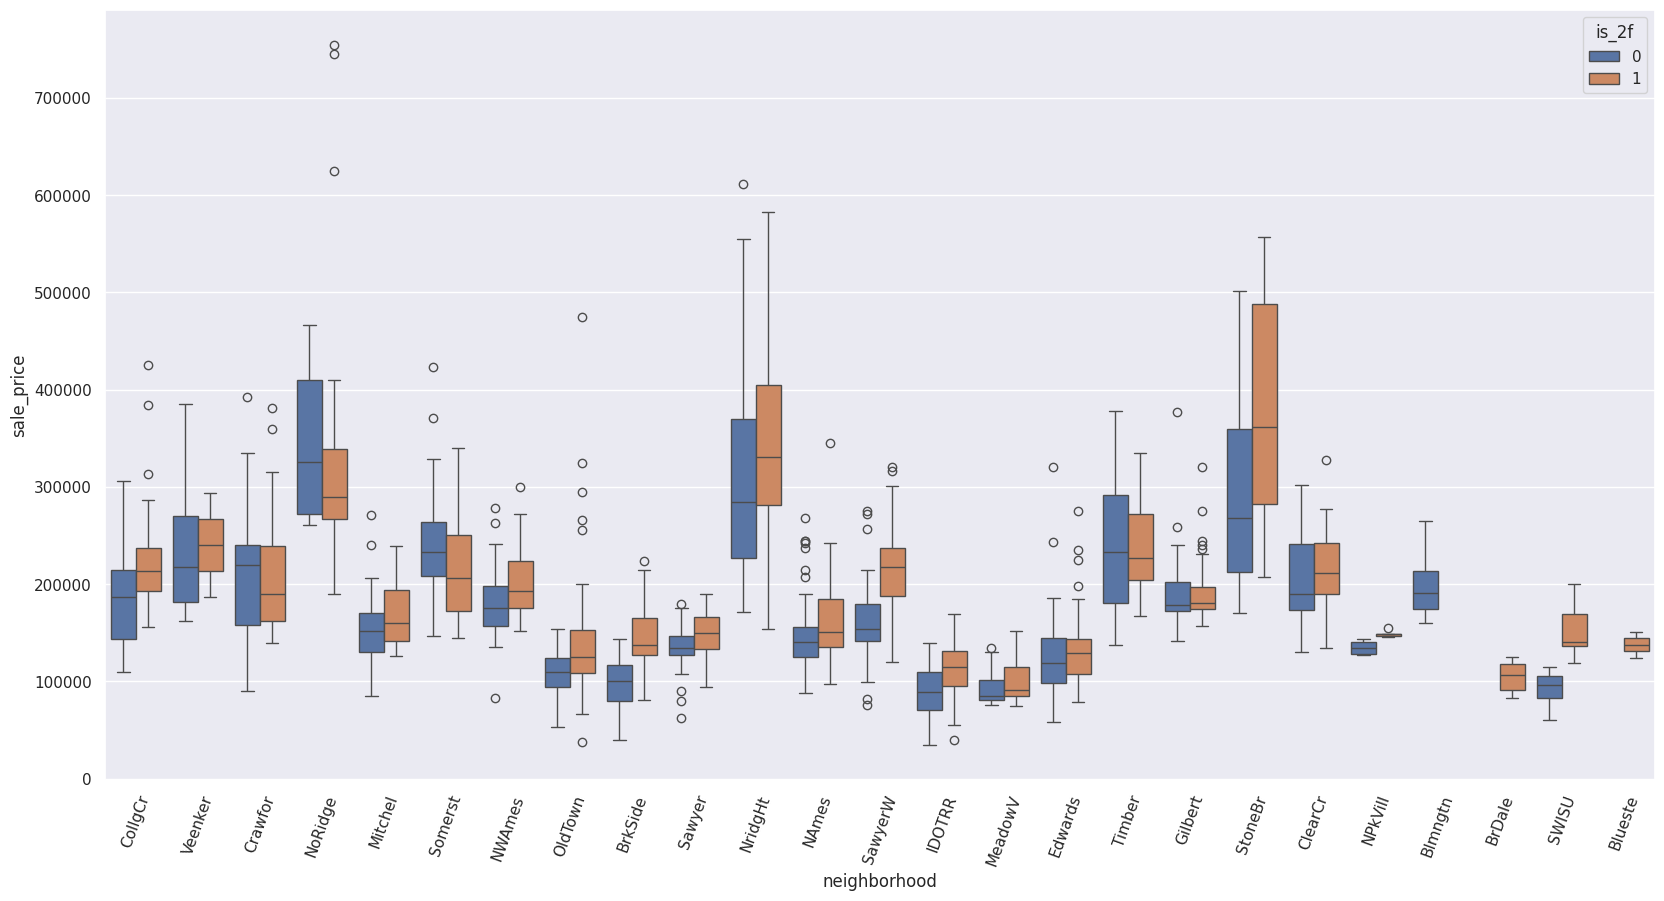

In [682]:
temp = train[gr_sf_cols + ["neighborhood","sale_price"]]

temp["is_2f"] = train["2nd_flr_sf"].apply(lambda x : 1 if x > 0 else 0)

sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="is_2f")

fig.tick_params(axis='x', rotation=70)

fig


<Axes: xlabel='gr_liv_area'>

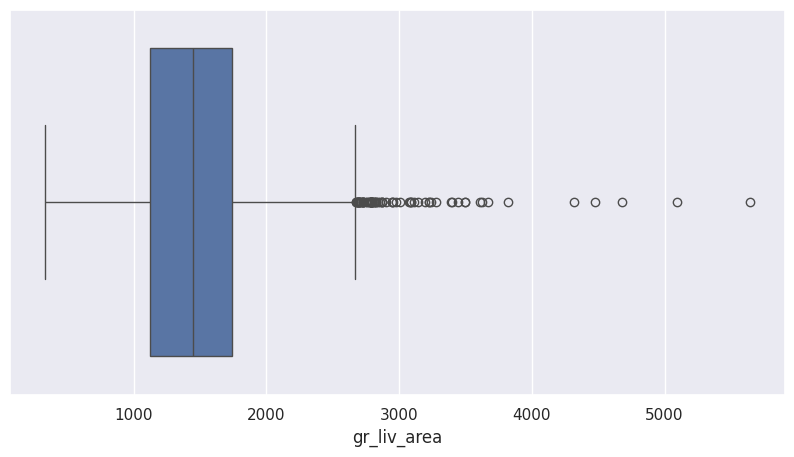

In [683]:

sns.set(rc={"figure.figsize": (10, 5)})

sns.boxplot(x=df["gr_liv_area"])

<Axes: xlabel='gr_liv_area', ylabel='sale_price'>

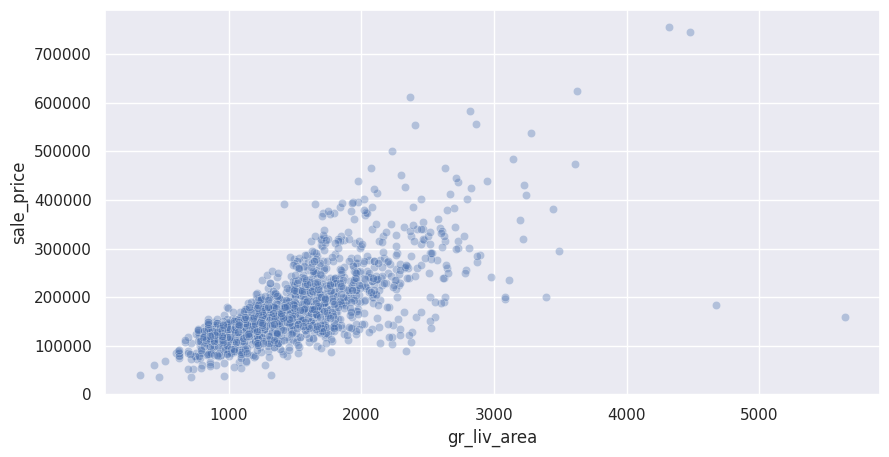

In [684]:
sns.scatterplot(data=train,
                x = "gr_liv_area",
                y = "sale_price",
                alpha = 0.35)

<Axes: xlabel='gr_liv_area', ylabel='sale_price'>

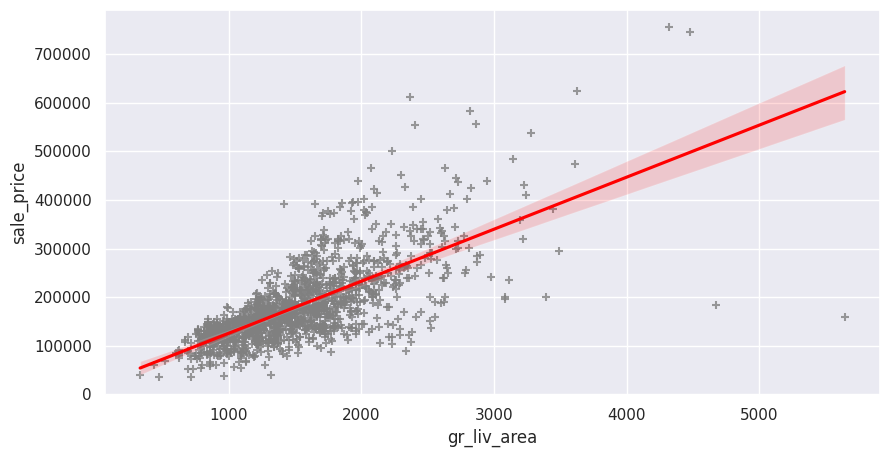

In [685]:
sns.regplot(data=train,
                x = "gr_liv_area",
                y = "sale_price",
                marker="+",
                line_kws={'color': 'red'}, 
                scatter_kws={'color': 'grey'})

In [686]:
out_tgr_idx = df[df["gr_liv_area"]>3500].index

len(out_tgr_idx)

9

In [687]:
for col in integer2:
    print(df[col].describe(), end="\n\n\n")

count    2919.000000
mean       69.943732
std        21.035815
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       200.000000
Name: lot_frontage, dtype: float64


count     2919.000000
mean      9991.791024
std       5336.095298
min       1300.000000
25%       7478.000000
50%       9453.000000
75%      11570.000000
max      50000.000000
Name: lot_area, dtype: float64


count    2919.000000
mean      101.412091
std       177.185045
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1200.000000
Name: mas_vnr_area, dtype: float64


count    2919.000000
mean      441.272011
std       455.606014
min         0.000000
25%         0.000000
50%       368.000000
75%       733.000000
max      5644.000000
Name: bsmt_fin_sf1, dtype: float64


count    2919.000000
mean       49.565262
std       169.179104
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: bs

In [688]:
# skew_features = df[integer2].apply(lambda x: skew(x)).sort_values(ascending=False)

# high_skew = skew_features[skew_features > 0.5]
# skew_index = high_skew.index

# for i in skew_index:
#     # print(i)
#     # print(i, features[i] + 1)
#     # print(i, boxcox_normmax(features[i] + 1 , method="mle"))
#     df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1, method="mle"))

In [689]:
# for col in integer2:
#     print(df[col].describe(), end="\n\n\n")

#### garage_area

In [690]:
df["garage_area"].describe()

count    2919.000000
mean      472.712573
std       215.535686
min         0.000000
25%       320.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: garage_area, dtype: float64

<Axes: xlabel='garage_area'>

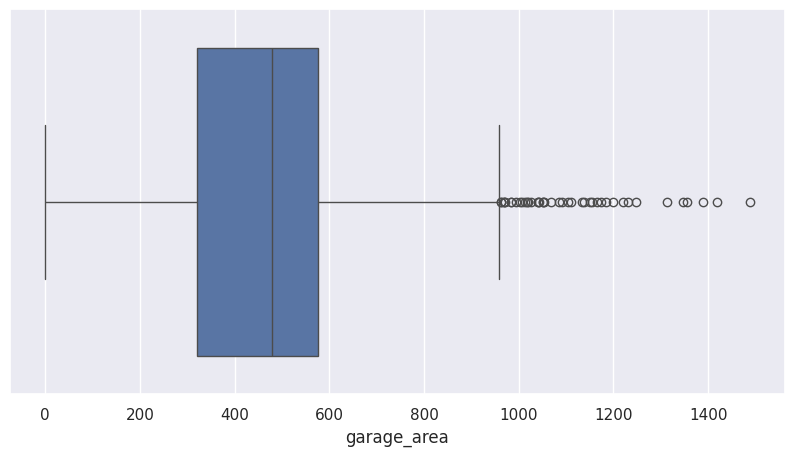

In [691]:
sns.boxplot(x = df["garage_area"])

<Axes: xlabel='garage_area', ylabel='sale_price'>

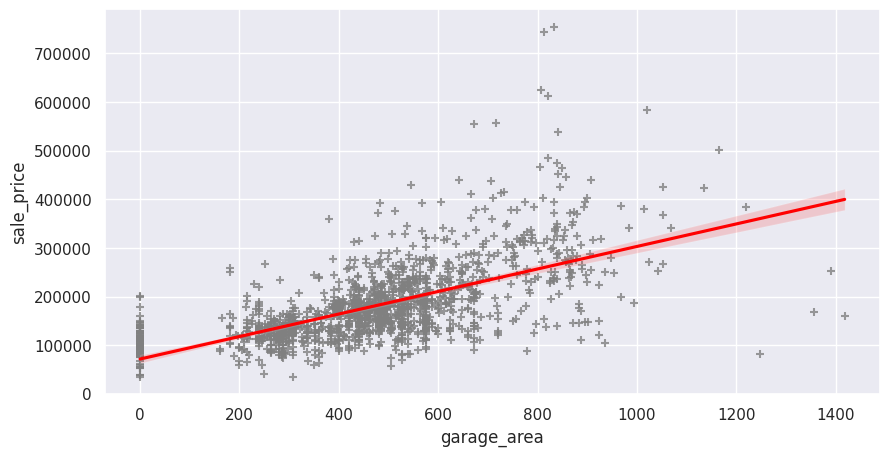

In [692]:
sns.regplot(data=train,
                x = "garage_area",
                y = "sale_price",
                marker="+",
                line_kws={'color': 'red'}, 
                scatter_kws={'color': 'grey'})

In [693]:
out_garage_area_idx = df[df["garage_area"] > 1000].index

df.loc[out_garage_area_idx,"garage_area"] = 1000

#### 목재 데크

In [694]:
df["wood_deck_sf"].describe()

count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max      1424.000000
Name: wood_deck_sf, dtype: float64

<Axes: xlabel='wood_deck_sf', ylabel='sale_price'>

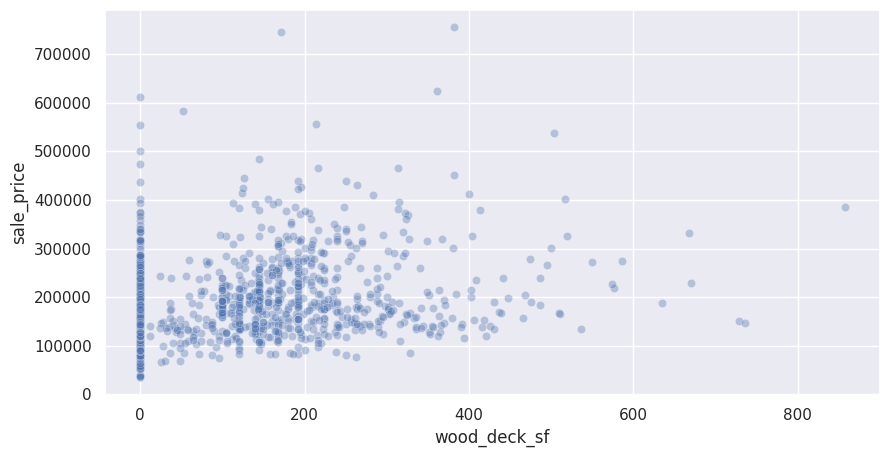

In [695]:
sns.scatterplot(data=train,
                x = "wood_deck_sf",
                y = "sale_price",
                alpha = 0.35)

<Axes: xlabel='wood_deck_sf', ylabel='sale_price'>

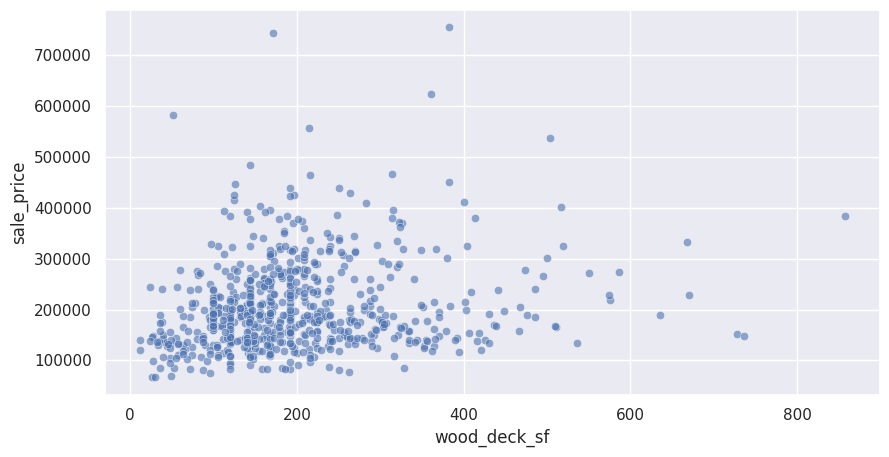

In [696]:
sns.scatterplot(data=train[train["wood_deck_sf"] > 0],
                x = "wood_deck_sf",
                y = "sale_price",
                alpha = 0.6)

/tmp/ipykernel_3473/387425828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["is_wd"] = temp["wood_deck_sf"].apply(lambda x : (1 if x > 0 else 0))


<Axes: xlabel='neighborhood', ylabel='sale_price'>

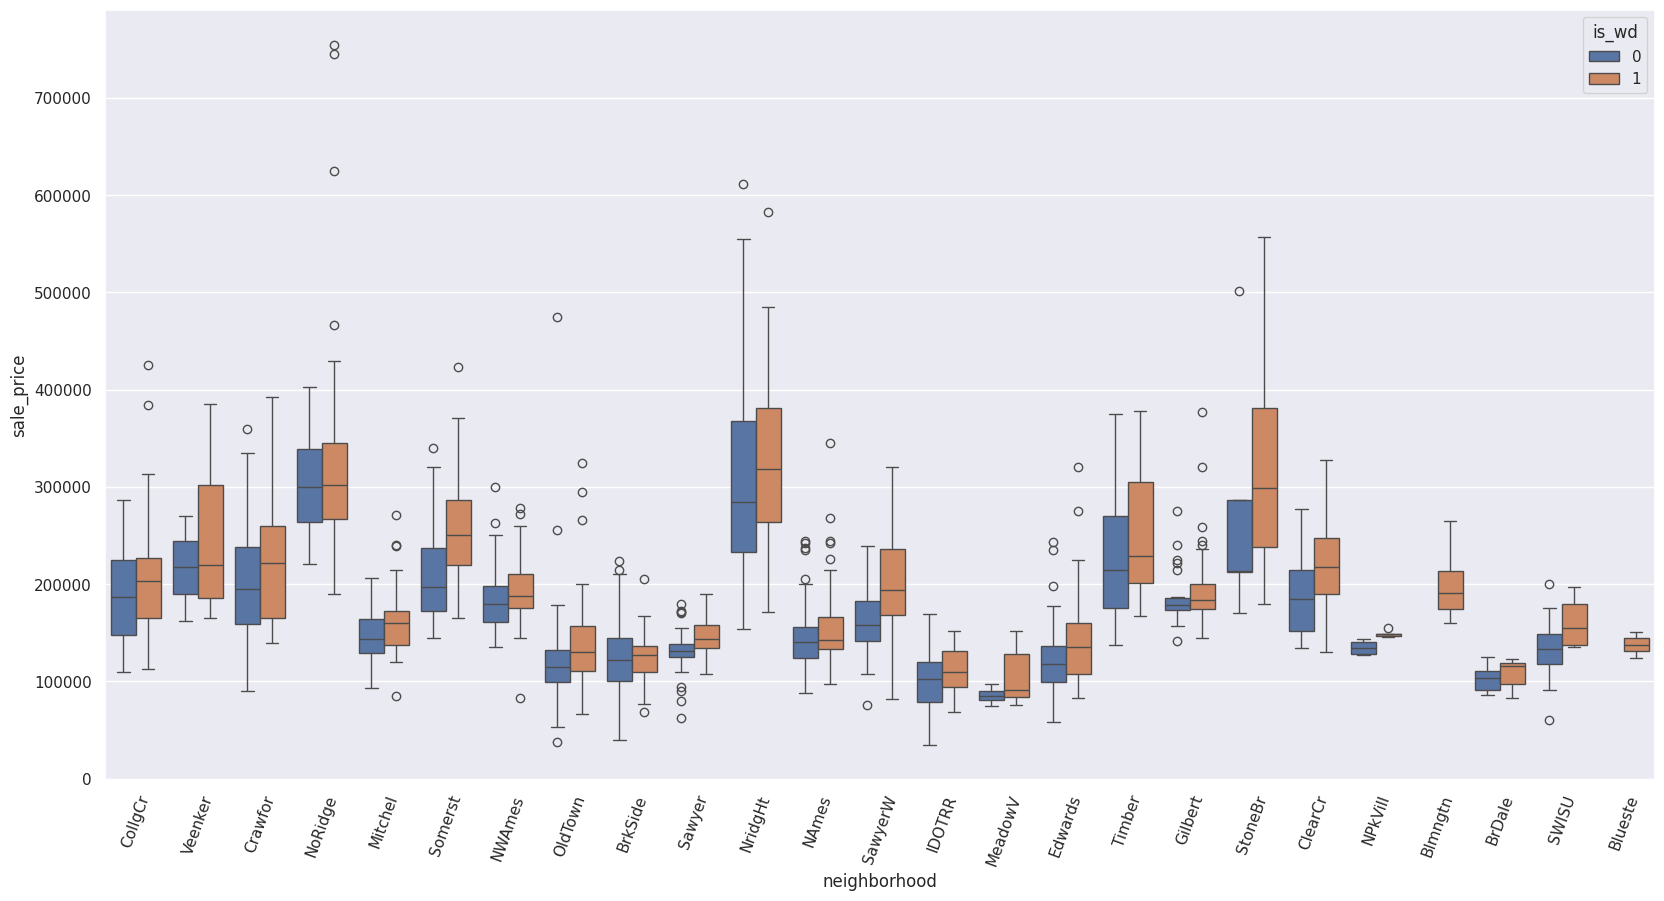

In [697]:
temp = train[["neighborhood","wood_deck_sf","sale_price"]]

temp["is_wd"] = temp["wood_deck_sf"].apply(lambda x : (1 if x > 0 else 0))

sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="is_wd")

fig.tick_params(axis='x', rotation=70)

fig

In [698]:
sns.set(rc={"figure.figsize": (8, 5)})

#### porch관련 컬럼

In [699]:
porch_cols = ["open_porch_sf","enclosed_porch_sf","3ssn_porch_sf","screen_porch_sf"]

df[porch_cols].describe()

,open_porch_sf,enclosed_porch_sf,3ssn_porch_sf,screen_porch_sf
count,2919.000000,2919.000000,2919.000000,2919.000000
mean,47.486811,23.098321,2.602261,16.062350
std,67.575493,64.244246,25.188169,56.184365
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000
75%,70.000000,0.000000,0.000000,0.000000
max,742.000000,1012.000000,508.000000,576.000000


/tmp/ipykernel_3473/200481120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["p_sf"] = temp["3ssn_porch_sf"] + temp["open_porch_sf"] + temp["enclosed_porch_sf"] + temp["screen_porch_sf"]
/tmp/ipykernel_3473/200481120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["is_porch"] = temp["p_sf"].apply(lambda x : (1 if x > 0 else 0))


<Axes: xlabel='neighborhood', ylabel='sale_price'>

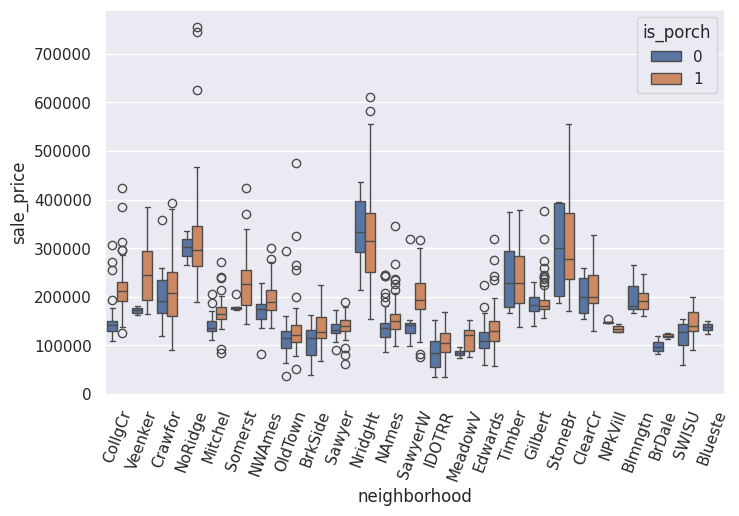

In [700]:
temp = train[["neighborhood","sale_price"]+porch_cols]

temp["p_sf"] = temp["3ssn_porch_sf"] + temp["open_porch_sf"] + temp["enclosed_porch_sf"] + temp["screen_porch_sf"]

temp["p_sf"].describe()


temp["is_porch"] = temp["p_sf"].apply(lambda x : (1 if x > 0 else 0))

# sns.set(rc={"figure.figsize": (20, 10)})

fig = sns.boxplot(data=temp, x="neighborhood", y="sale_price", hue="is_porch")

fig.tick_params(axis='x', rotation=70)

fig

### 이산형 변수의 이상치

In [701]:
integer1 = ["bsmt_full_bath","bsmt_half_bath","full_bath","half_bath","bedroom","kitchen","tot_rms_abv_grd","garage_cars","fireplaces"]




NameError: name 'train' is not defined

## 데이터 저장

In [702]:
df.to_csv(os.path.join(data_path,"feature_out_v1.csv"), index=False)